# Finance

In [294]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, f1_score, 
  roc_auc_score, roc_curve, auc, confusion_matrix, make_scorer)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import phik
import pickle
import math
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from keras_tuner import BayesianOptimization

In [248]:
# Upload data
finance_train_df = pd.read_csv('train_data.csv')
finance_test_hidden_df = pd.read_csv('test_data_hidden.csv')
finance_test_df = pd.read_csv('test_data.csv')

## Project Task: Week 1

In [249]:
# df shapes
print(finance_train_df.shape)
print(finance_test_hidden_df.shape)
print(finance_test_df.shape)

(227845, 31)
(56962, 31)
(56962, 30)


In [250]:
# sample data
finance_train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,38355.0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,...,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894,49.67,0
1,22555.0,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,...,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595998,-0.220086,16.94,0
2,2431.0,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,...,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623,1.00,0
3,86773.0,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,...,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635,10.78,0
4,127202.0,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,...,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888,39.96,0


We have 28 features (encoded-> result of PCA output), timestamp and amount with class labels (0,1) as froud and non-froud.

### EDA

In [251]:
# info
finance_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227845 non-null  float64
 1   V1      227845 non-null  float64
 2   V2      227845 non-null  float64
 3   V3      227845 non-null  float64
 4   V4      227845 non-null  float64
 5   V5      227845 non-null  float64
 6   V6      227845 non-null  float64
 7   V7      227845 non-null  float64
 8   V8      227845 non-null  float64
 9   V9      227845 non-null  float64
 10  V10     227845 non-null  float64
 11  V11     227845 non-null  float64
 12  V12     227845 non-null  float64
 13  V13     227845 non-null  float64
 14  V14     227845 non-null  float64
 15  V15     227845 non-null  float64
 16  V16     227845 non-null  float64
 17  V17     227845 non-null  float64
 18  V18     227845 non-null  float64
 19  V19     227845 non-null  float64
 20  V20     227845 non-null  float64
 21  V21     22

In [252]:
finance_train_df.isna().all().sum()

0

In [253]:
finance_train_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

There is no missing values and we have numeric data present.

In [254]:
# get statistical info
stats_data = finance_train_df.describe()
stats_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94752.853076,-0.003321,-0.001652,0.001066,-0.000374,0.000877,0.000770,-0.000035,0.001625,-0.000391,...,0.000563,0.001234,-0.001002,0.000254,0.000218,-0.001128,-0.000346,0.000498,88.522327,0.001729
std,47500.410602,1.963028,1.661178,1.516107,1.415061,1.367074,1.325341,1.220384,1.192648,1.097367,...,0.734187,0.724544,0.625165,0.606012,0.521348,0.482314,0.400286,0.331184,248.100141,0.041548
min,0.000000,-56.407510,-72.715728,-32.965346,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54182.000000,-0.922851,-0.598040,-0.889246,-0.848884,-0.690811,-0.767803,-0.554761,-0.207838,-0.643365,...,-0.228031,-0.540792,-0.162264,-0.354099,-0.317450,-0.327910,-0.070986,-0.053117,5.590000,0.000000
50%,84607.000000,0.012663,0.066665,0.182170,-0.019309,-0.055243,-0.273025,0.040409,0.022928,-0.050932,...,-0.028807,0.008697,-0.011614,0.041212,0.016221,-0.053257,0.001315,0.011216,22.000000,0.000000
75%,139340.000000,1.314821,0.804401,1.029449,0.744822,0.610852,0.400298,0.570631,0.327854,0.596671,...,0.186852,0.529535,0.147067,0.440051,0.351214,0.239885,0.091105,0.078458,77.070000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,22.529298,36.877368,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,6.070850,3.463246,12.152401,33.847808,19656.530000,1.000000


In [255]:
finance_train_df[finance_train_df['Class'] == 0].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,...,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.0
mean,94778.158337,0.005102,-0.008137,0.013458,-0.008269,0.006550,0.003117,0.009964,0.000961,0.004161,...,-0.000736,0.001222,-0.000959,0.000431,0.000151,-0.001214,-0.000628,0.000349,88.455144,0.0
std,47497.567552,1.932798,1.645089,1.457120,1.398253,1.342508,1.322856,1.156654,1.154287,1.087586,...,0.712756,0.722077,0.621716,0.606126,0.520723,0.482369,0.396085,0.330667,248.066088,0.0
min,0.000000,-56.407510,-72.715728,-32.965346,-5.683171,-42.147898,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.0
25%,54208.000000,-0.920154,-0.599136,-0.883556,-0.850301,-0.688601,-0.766491,-0.552208,-0.207839,-0.640614,...,-0.228124,-0.540768,-0.162080,-0.353897,-0.317450,-0.328061,-0.071007,-0.053107,5.640000,0.0
50%,84617.000000,0.015404,0.064922,0.184336,-0.021897,-0.054227,-0.272081,0.041373,0.022618,-0.049554,...,-0.029115,0.008584,-0.011555,0.041289,0.016128,-0.053348,0.001194,0.011169,22.000000,0.0
75%,139354.000000,1.315404,0.801069,1.030604,0.739027,0.611240,0.401261,0.571178,0.326785,0.597654,...,0.186010,0.529325,0.146966,0.440280,0.351009,0.239648,0.090640,0.078171,77.000000,0.0
max,172792.000000,2.454930,18.183626,9.382558,16.875344,34.801666,22.529298,36.877368,18.709255,15.594995,...,22.580675,10.503090,22.528412,4.022866,6.070850,3.463246,12.152401,33.847808,19656.530000,0.0


In [256]:
finance_train_df[finance_train_df['Class'] == 1].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,...,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.0
mean,80144.459391,-4.865812,3.741947,-7.152669,4.557039,-3.274295,-1.354128,-5.772326,0.384907,-2.628401,...,0.750538,0.008633,-0.025738,-0.101968,0.038909,0.048557,0.162197,0.086224,127.306523,1.0
std,46947.027931,6.948331,4.413446,7.239645,2.917991,5.442972,1.930181,7.463612,7.306385,2.576605,...,4.233532,1.609687,1.697116,0.526688,0.805024,0.447566,1.438879,0.548258,264.533907,0.0
min,472.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-5.773192,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.552593,0.000000,1.0
25%,41250.500000,-5.972454,1.180534,-8.813291,2.331443,-4.801176,-2.492665,-8.589239,-0.169625,-3.880445,...,0.040122,-0.554402,-0.339114,-0.436065,-0.318323,-0.255973,-0.009170,-0.116723,1.000000,1.0
50%,74647.500000,-2.331289,2.744670,-5.154274,4.146134,-1.621234,-1.373933,-3.016983,0.615604,-2.179119,...,0.615305,0.091214,-0.075809,-0.060737,0.076685,0.000308,0.404295,0.147380,11.395000,1.0
75%,122960.500000,-0.442917,5.204418,-2.215501,6.390866,0.065251,-0.356945,-1.009233,1.757590,-0.790027,...,1.325559,0.623456,0.287309,0.291641,0.464751,0.404597,0.850654,0.387926,106.385000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,1.246604,3.052358,1.779364,2125.870000,1.0


From the above statistical data, we can see, there are differences between both the class labels based on the mean, min & max values for different features and amount also. So these features can be useful.

#### Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean) with unit standard deviation

In [257]:
stats_data.iloc[1:3, 1:-2].T

,mean,std
V1,-0.003321,1.963028
V2,-0.001652,1.661178
V3,0.001066,1.516107
V4,-0.000374,1.415061
V5,0.000877,1.367074
V6,0.000770,1.325341
V7,-0.000035,1.220384
V8,0.001625,1.192648
V9,-0.000391,1.097367
V10,-0.000794,1.087268


We can see most of the values of features (V1- V28) are having mean and std close to 0 and 1 resectively.

####  Check the class count for each class. It’s a class Imbalance problem.

In [258]:
print('Class counts')
print(finance_train_df['Class'].value_counts())
print(finance_train_df['Class'].value_counts(normalize = True))

Class counts
0    227451
1       394
Name: Class, dtype: int64
0    0.998271
1    0.001729
Name: Class, dtype: float64


In [259]:
finance_train_df[finance_train_df['Amount'] <= 0].size

45477

We have 45477 invalid data as well, lets get rid of them. (transactions can be made only with positive number amounts)

In [260]:
finance_train_df = finance_train_df[finance_train_df['Amount'] > 0]

In [261]:
print('Class counts')
print(finance_train_df['Class'].value_counts())
print(finance_train_df['Class'].value_counts(normalize = True))

Class counts
0    226001
1       377
Name: Class, dtype: int64
0    0.998335
1    0.001665
Name: Class, dtype: float64


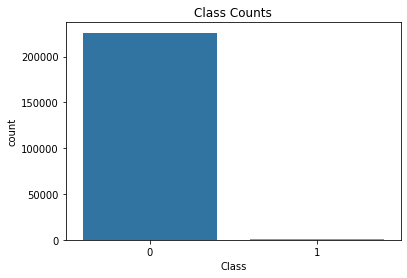

In [262]:
sns.countplot(x = finance_train_df['Class'])
plt.title('Class Counts')
plt.show()

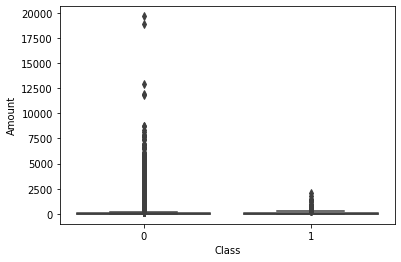

In [263]:
sns.boxplot(x='Class', y='Amount', data=finance_train_df)
plt.show()

In [264]:
finance_train_df.groupby('Class')['Amount'].sum() / finance_train_df['Amount'].sum()

Class
0    0.997513
1    0.002487
Name: Amount, dtype: float64

From the above result and plot, we can see, we have highly imbalanced data where non-froud count is way higher than the number of frouds.

Also we have 99.8% non-foundulant and 0.2% froudulant transactions.

#### Find if there is any connection between Time, Amount, and the transaction being fraudulent.

Lets try some plotting to get some insights on the class, time and amount relationships. Lets try plotting on sample of data.

We can also try to find the relation between other encoded features and class labels.

In [265]:
class0_amt_med = finance_train_df[finance_train_df['Class'] == 0]['Amount'].median()
class1_amt_med = finance_train_df[finance_train_df['Class'] == 1]['Amount'].median()

print('Median amount for class 0 ', class0_amt_med)
print('Median amount for class 1 ', class1_amt_med)

Median amount for class 0  22.5
Median amount for class 1  18.0


In [266]:
finance_train_df.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,226001.0,89.022663,248.759075,0.01,5.99,22.5,77.95,19656.53
1,377.0,133.047135,269.028423,0.01,1.00,18.0,112.45,2125.87


We can see, for class 1 (froud), amount has comparatively higher mean value, but has less median (50%) value.

Lets sample the train data and proceed with further EDA.

In [267]:
sample_data = finance_train_df.sample(frac=1)

data0 = sample_data[sample_data['Class'] == 0][:500]
data1 = sample_data[sample_data['Class'] == 1]
data = pd.concat([data0, data1], axis=0)
print(data.shape)

(877, 31)


In [268]:
data['Class'].value_counts()

0    500
1    377
Name: Class, dtype: int64

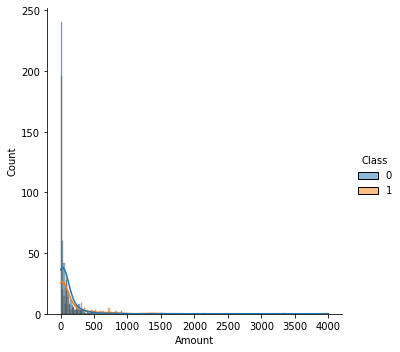

In [269]:
sns.displot(data, x= 'Amount', hue= 'Class', kde=True)
plt.show()

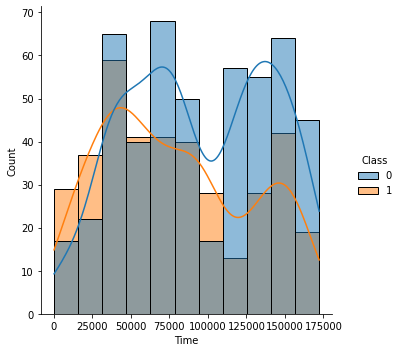

In [270]:
sns.displot(data, x= 'Time', hue= 'Class', kde= True)
plt.show()

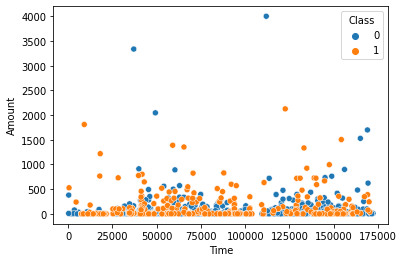

In [271]:
sns.scatterplot(data=data, x="Time", y="Amount", hue="Class")
plt.show()

From the above two plots, we cant find any specific relationship between the three data.

But from the scatterplot, we can see, most of the froud transactions have less amount, but still few of them has large amount.

Also, there are certain timestamps, where froud counts are more than the non-froud counts as compared to other timestamps.

In [272]:
corr = data.corr()['Class']['Amount']
corr

0.06042151045900016

We dont get much inference from the correlation. We can try phik library to get the relationship between class, time and amount.

In [273]:
corr = data.phik_matrix().loc['Class', ['Time', 'Amount', 'Class']].to_dict()
corr

interval columns not set, guessing: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


{'Time': 0.30580993495716885, 'Amount': 0.13369615362211948, 'Class': 1.0}

We can see, time got higher correlation value than amount for class labels.

Lets find out the relationship between other features and class labels.

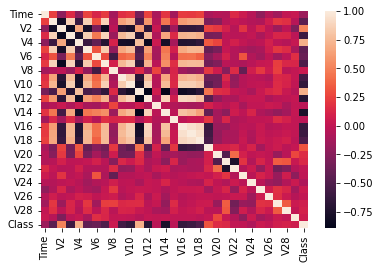

In [274]:
corr = data.corr()
sns.heatmap(corr)
plt.show()

All the features are correlated with each other and for amount, there are few possitively correlated features and some are negatively correlated.

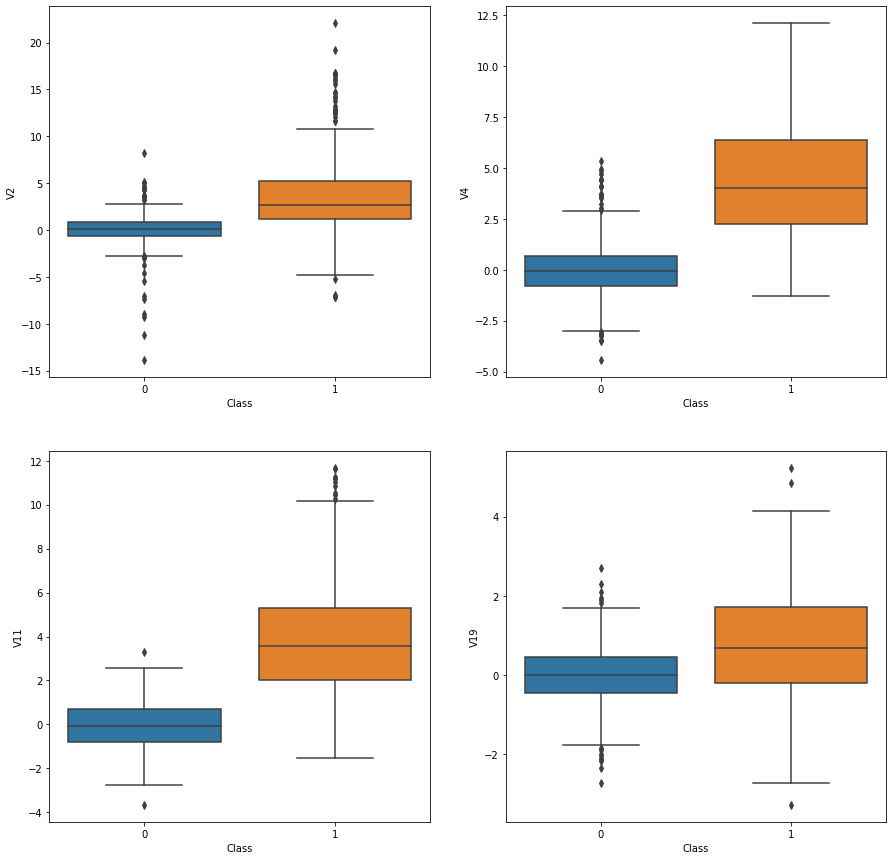

In [275]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
y = 0;
for i, f in enumerate(['V2', 'V4', 'V11', 'V19']):
  i, j = divmod(y, 2)
  sns.boxplot(y=f, x= 'Class', data= data, ax= ax[i, j])
  y += 1

plt.show()

Above features are negatively correlated with the class label, so low value indicates class 0.

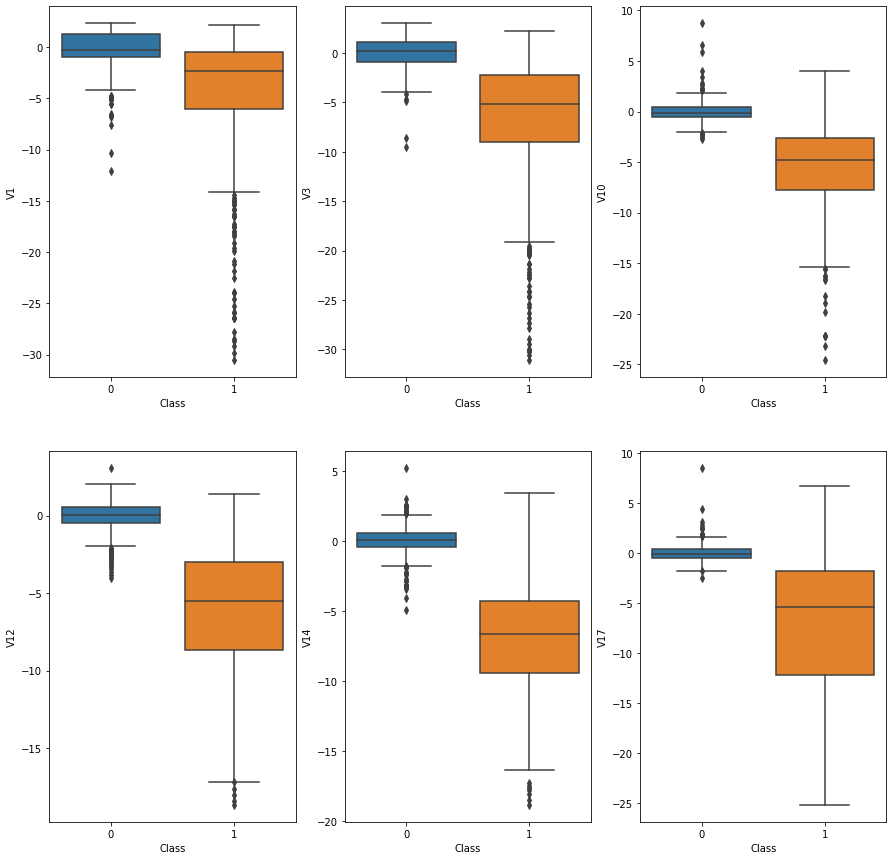

In [276]:
fig, ax = plt.subplots(2,3, figsize=(15,15))
y = 0;
for i, f in enumerate(['V1', 'V3', 'V10', 'V12', 'V14', 'V17']):
  i, j = divmod(y, 3)
  sns.boxplot(y=f, x= 'Class', data= data, ax= ax[i, j])
  y += 1

plt.show()

Above features are positively correlated with the class label. So higher value indicates class 0.

We can see, there are some features which properly classifies both the class labels.

So we can consider these useful features on modeling.

Now lets try to visualize the features with TSNE.

In [278]:
X = data.drop('Class', axis=1)
y = data['Class']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


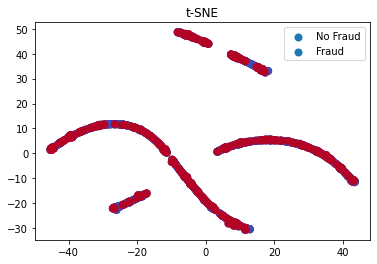

In [298]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE')
plt.legend()
plt.show()

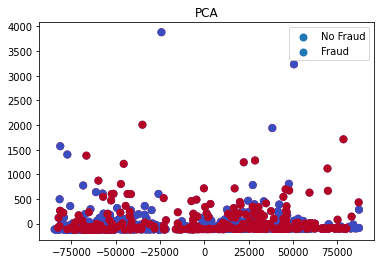

In [297]:
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
plt.scatter(X_pca[:,0], X_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('PCA')
plt.legend()
plt.show()

#### Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.

We can go for both oversampling and undersampling approach and compare the result. But before that, lets standardize the data as we have time and amount with higher scale than others.

In [143]:
train_X = finance_train_df.drop(['Class'], axis=1)
train_y = finance_train_df['Class']

test_X = finance_test_hidden_df.drop(['Class'], axis=1)
test_y = finance_test_hidden_df['Class']

In [144]:
stdsc = StandardScaler()

train_X = stdsc.fit_transform(train_X)
test_X = stdsc.transform(test_X)

In [145]:
train_y.reset_index(drop= True, inplace=True)

In [148]:
train_df = pd.DataFrame(train_X)
train_df.columns = finance_train_df.columns[:-1]
train_df['Class'] = train_y
train_df.to_pickle('finance_train.pkl')

##### Oversampling

In [ ]:
osmp = RandomOverSampler(sampling_strategy= 'minority')
train_X_ovr, train_y_ovr = osmp.fit_resample(train_X, train_y)

print(train_X_ovr.shape)
print(train_y_ovr.shape)
print(train_y_ovr.value_counts())

(452002, 30)
(452002,)
0    226001
1    226001
Name: Class, dtype: int64


In [ ]:
train_ovr_df = pd.DataFrame(train_X_ovr)
train_ovr_df.columns = finance_train_df.columns[:-1]
train_ovr_df['Class'] = train_y_ovr

train_ovr_df.shape

(452002, 31)

##### Undersampling

In [ ]:
usmp = RandomUnderSampler(sampling_strategy=0.5)
train_X_udr, train_y_udr = usmp.fit_resample(train_X, train_y)

print(train_X_udr.shape)
print(train_y_udr.shape)
print(train_y_udr.value_counts())

(1131, 30)
(1131,)
0    754
1    377
Name: Class, dtype: int64


In [ ]:
train_udr_df = pd.DataFrame(train_X_udr)
train_udr_df.columns = finance_train_df.columns[:-1]
train_udr_df['Class'] = train_y_udr

train_udr_df.shape

(1131, 31)

In [ ]:
test_df = pd.DataFrame(test_X)
test_df.columns = finance_train_df.columns[:-1]
test_df['Class'] = test_y

test_df.shape

(56962, 31)

In [ ]:
train_ovr_df.to_pickle('finance_ovr_train.pkl')
train_udr_df.to_pickle('finance_udr_train.pkl')
test_df.to_pickle('finance_test.pkl')

We have standardized, over and under sampled our data and saved it as pickle files for future purposes.

#### Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project

In [215]:
def getPerformance(y_train, y_pred_train, y_test, y_pred_test, name):
  print('\nModel performance ' + name)
  print('\naccuracy score train', accuracy_score(y_train, y_pred_train))
  print('accuracy score test', accuracy_score(y_test, y_pred_test))
  print('\nTrain classification report: ' + name + '\n')
  print(classification_report(y_train, y_pred_train))
  print('\nTest classification report: ' + name + '\n')
  print(classification_report(y_test, y_pred_test))
  print('\n')
  sns.heatmap(confusion_matrix(y_train, y_pred_train), annot= True, cbar= False)
  plt.title('Train confusion matrix: ' + name)
  plt.show()
  sns.heatmap(confusion_matrix(y_test, y_pred_test), annot= True, cbar= False)
  plt.title('Test confusion matrix: ' + name)
  plt.show()
  print('\nroc auc score train {}'.format(roc_auc_score(y_train, y_pred_train)))
  fpr, tpr, th = roc_curve(y_train, y_pred_train)
  auc_val = auc(fpr, tpr)
  plt.title(name + ' Train Receiver Operating Characteristic Curve')
  plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_val))
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  print('\nroc auc score test {}'.format(roc_auc_score(y_test, y_pred_test)))
  fpr, tpr, th = roc_curve(y_test, y_pred_test)
  auc_val = auc(fpr, tpr)
  plt.title(name + ' Test Receiver Operating Characteristic Curve')
  plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_val))
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### Modeling Techniques

We can try out different models like naive bayes, svm, logistic regression and also three based models like random forest and xgboot with both the data (oversampled and undersampled). In addition to that we can do hyper-parameter tunning in parallel.

Before that lets upload our processed data.

In [238]:
train_ovr_df = pd.read_pickle('finance_ovr_train.pkl')
train_udr_df = pd.read_pickle('finance_udr_train.pkl')
test_df = pd.read_pickle('finance_test.pkl')

In [239]:
train_ovr_X = train_ovr_df.drop(['Class'], axis=1)
train_ovr_y = train_ovr_df['Class']

train_udr_X = train_udr_df.drop(['Class'], axis=1)
train_udr_y = train_udr_df['Class']

test_X = test_df.drop(['Class'], axis=1)
test_y = test_df['Class']

In [240]:
x_ovr_train, x_ovr_test, y_ovr_train, y_ovr_test = train_test_split(train_ovr_X, train_ovr_y, 
                                                                     stratify= train_ovr_y,
                                                                     test_size= 0.2, random_state= 0)

In [241]:
x_udr_train, x_udr_test, y_udr_train, y_udr_test = train_test_split(train_udr_X, train_udr_y, 
                                                                     stratify= train_udr_y,
                                                                     test_size= 0.2, random_state= 0)

In [242]:
print(x_ovr_train.shape)
print(x_ovr_test.shape)
print(y_ovr_train.shape)
print(y_ovr_test.shape)

(361601, 30)
(90401, 30)
(361601,)
(90401,)


In [243]:
print(x_udr_train.shape)
print(x_udr_test.shape)
print(y_udr_train.shape)
print(y_udr_test.shape)

(904, 30)
(227, 30)
(904,)
(227,)


In [244]:
print(test_X.shape)
print(test_y.shape)

(56962, 30)
(56962,)


In [245]:
def buildModel(model, params, x_train, y_train, x_test, y_test, test_x, test_y, model_name):
  print('Building model ' + model_name + '.......')
  gs = GridSearchCV(model, params, refit=True, scoring=make_scorer(f1_score , average='macro'))
  gs.fit(x_train, y_train)
  y_train_pred = gs.predict(x_train)
  y_test_pred = gs.predict(x_test)
  print('\nBest score ', gs.best_score_)
  print('Best param ', gs.best_params_)
  best_model = gs.best_estimator_
  print('Best model ', best_model)
  getPerformance(y_train, y_train_pred, y_test, y_test_pred, model_name)
  test_y_pred = best_model.predict(test_X)
  print('\nTest accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
  print('Classification report\n')
  print(classification_report(test_y, test_y_pred))
  print('\nCompleted for ' + model_name)
  print('Saving model as ' + model_name + '.pkl')
  pickle.dump(best_model, open(model_name + '.pkl', 'wb'))

#### Naive Bayes

##### Naive Bayes with over sampled data

Building model Oversampled GNB.......

Best score  0.9189955854298983
Best param  {'priors': [0.25, 0.75], 'var_smoothing': 0.0006579332246575676}
Best model  GaussianNB(priors=[0.25, 0.75], var_smoothing=0.0006579332246575676)

Model performance Oversampled GNB

accuracy score train 0.9192452454500956
accuracy score test 0.9205429143482926

Train classification report: Oversampled GNB

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    180800
           1       0.97      0.86      0.91    180801

    accuracy                           0.92    361601
   macro avg       0.92      0.92      0.92    361601
weighted avg       0.92      0.92      0.92    361601


Test classification report: Oversampled GNB

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     45201
           1       0.97      0.87      0.92     45200

    accuracy                           0.92     90401
   macro avg       

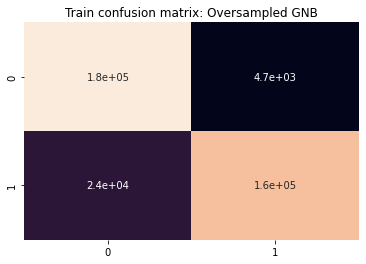

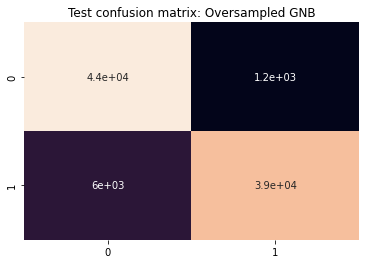


roc auc score train 0.919245396426169


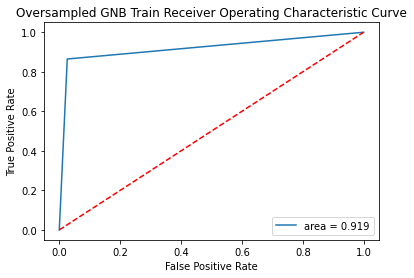


roc auc score test 0.9205423187931663


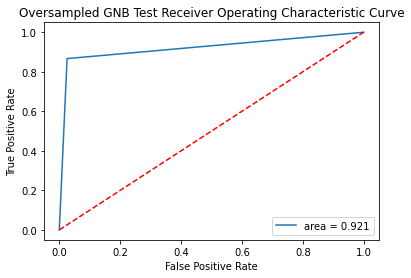


Test accuracy score 0.9732628770057231 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.82      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.89      0.54     56962
weighted avg       1.00      0.97      0.98     56962


Completed for Oversampled GNB
Saving model as Oversampled GNB.pkl


In [ ]:
gnb_ovr = GaussianNB()

gnb_params = {'var_smoothing': np.logspace(0,-9, num=100), 'priors': [[0.5, 0.5], [0.25, 0.75], [0.75,0.25]]}

buildModel(gnb_ovr, gnb_params, x_ovr_train, y_ovr_train, x_ovr_test, y_ovr_test, test_X, test_y, 'Oversampled GNB')

We are getting very good performance on the oversampled data and wih the test data, it gave reasonable f1-score.

##### Naive Bayes with under sampled data

Building model Undersampled GNB.......

Best score  0.9200576725202432
Best param  {'priors': [0.5, 0.5], 'var_smoothing': 0.004328761281083057}
Best model  GaussianNB(priors=[0.5, 0.5], var_smoothing=0.004328761281083057)

Model performance Undersampled GNB

accuracy score train 0.9303097345132744
accuracy score test 0.9383259911894273

Train classification report: Undersampled GNB

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       603
           1       0.95      0.83      0.89       301

    accuracy                           0.93       904
   macro avg       0.94      0.91      0.92       904
weighted avg       0.93      0.93      0.93       904


Test classification report: Undersampled GNB

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       151
           1       0.96      0.86      0.90        76

    accuracy                           0.94       227
   macro avg       0.

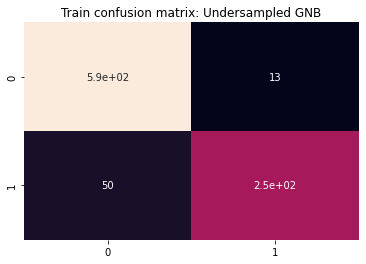

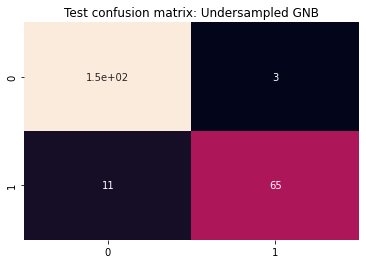


roc auc score train 0.9061640854421139


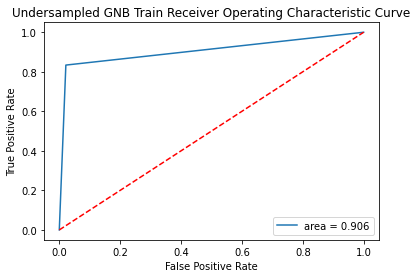


roc auc score test 0.9176978041129313


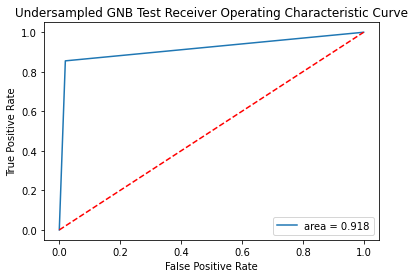


Test accuracy score 0.9698219865875496 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.82      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.89      0.53     56962
weighted avg       1.00      0.97      0.98     56962


Completed for Undersampled GNB
Saving model as Undersampled GNB.pkl


In [ ]:
gnb_udr = GaussianNB()

gnb_params = {'var_smoothing': np.logspace(0,-9, num=100), 'priors': [[0.5, 0.5], [0.25, 0.75], [0.75,0.25]]}

buildModel(gnb_udr, gnb_params, x_udr_train, y_udr_train, x_udr_test, y_udr_test, test_X, test_y, 'Undersampled GNB')

Undersampled Gaussian Naive Bayes performed better than the oversampled model in terms of f1-score on training data. But for the test, both gave similar performance. We can choose oversampled naive bayes model.

#### SVC

##### SVC with oversampled data

Building model Oversampled SVC.......

Best score  0.9580153162855138
Best param  {'alpha': 0.0001, 'penalty': 'l1'}
Best model  SGDClassifier(class_weight='balanced', penalty='l1')

Model performance Oversampled SVC

accuracy score train 0.9531859701715427
accuracy score test 0.9534075950487273

Train classification report: Oversampled SVC

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    180800
           1       0.97      0.94      0.95    180801

    accuracy                           0.95    361601
   macro avg       0.95      0.95      0.95    361601
weighted avg       0.95      0.95      0.95    361601


Test classification report: Oversampled SVC

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     45201
           1       0.97      0.94      0.95     45200

    accuracy                           0.95     90401
   macro avg       0.95      0.95      0.95     90401
weighted av

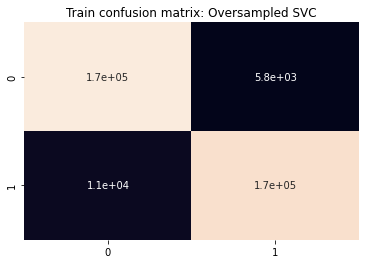

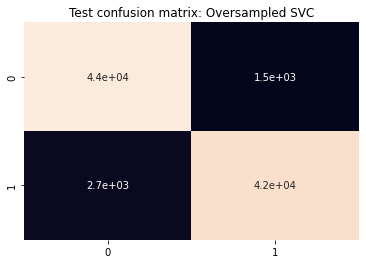


roc auc score train 0.95318601020016


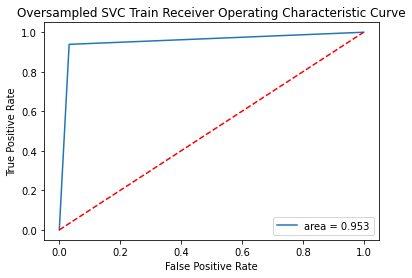


roc auc score test 0.9534074411091616


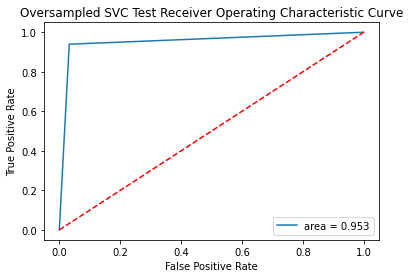


Test accuracy score 0.966960429760191 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.89      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962


Completed for Oversampled SVC
Saving model as Oversampled SVC.pkl


In [ ]:
svc_ovr = SGDClassifier(loss='hinge', class_weight='balanced')

svc_params = {'alpha' : [0.0001, 0.001, 0.01, 0.1], 'penalty' : ['l2', 'l1', 'none']}

buildModel(svc_ovr, svc_params, x_ovr_train, y_ovr_train, x_ovr_test, y_ovr_test, test_X, test_y, 'Oversampled SVC')

SVC gave similar performance as undersampled the naive bayes model till now. Lets try out the undersampled svc.

##### Undersampled SVC

Building model Undersampled SVC.......

Best score  0.947805054083058
Best param  {'alpha': 0.1, 'penalty': 'l2'}
Best model  SGDClassifier(alpha=0.1, class_weight='balanced')

Model performance Undersampled SVC

accuracy score train 0.9612831858407079
accuracy score test 0.9515418502202643

Train classification report: Undersampled SVC

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       603
           1       0.97      0.91      0.94       301

    accuracy                           0.96       904
   macro avg       0.97      0.95      0.96       904
weighted avg       0.96      0.96      0.96       904


Test classification report: Undersampled SVC

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       151
           1       0.97      0.88      0.92        76

    accuracy                           0.95       227
   macro avg       0.96      0.93      0.94       227
weighted avg  

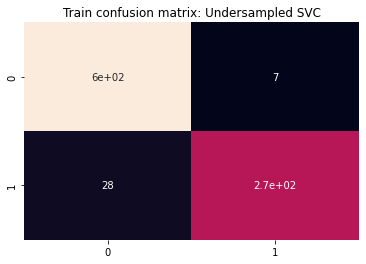

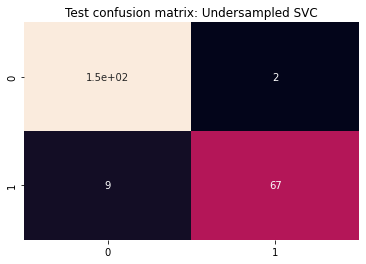


roc auc score train 0.9476840603185621


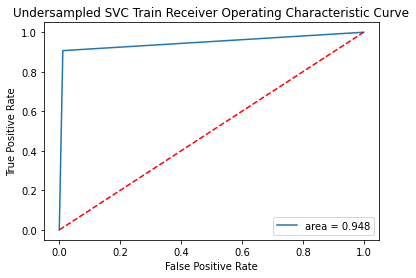


roc auc score test 0.9341669571279192


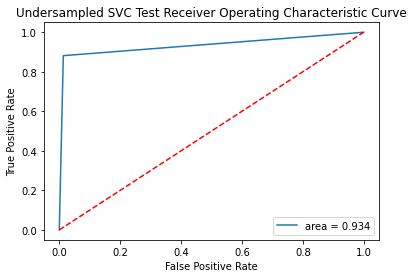


Test accuracy score 0.985604438046417 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.87      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.58     56962
weighted avg       1.00      0.99      0.99     56962


Completed for Undersampled SVC
Saving model as Undersampled SVC.pkl


In [ ]:
svc_udr = SGDClassifier(loss='hinge', class_weight='balanced')

svc_params = {'alpha' : [0.0001, 0.001, 0.01, 0.1], 'penalty' : ['l2', 'l1', 'none']}

buildModel(svc_udr, svc_params, x_udr_train, y_udr_train, x_udr_test, y_udr_test, test_X, test_y, 'Undersampled SVC')

SVC with unsersampled data performed better than others.

#### Logistic Regression

##### Logistic Regression with oversampled data

Building model Oversampled LR.......


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is n


Best score  0.9520621575772905
Best param  {'C': 1000.0, 'penalty': 'l2'}
Best model  LogisticRegression(C=1000.0, class_weight='balanced', solver='liblinear')

Model performance Oversampled LR

accuracy score train 0.9516704876369257
accuracy score test 0.9521907943496201

Train classification report: Oversampled LR

              precision    recall  f1-score   support

           0       0.93      0.98      0.95    180800
           1       0.98      0.93      0.95    180801

    accuracy                           0.95    361601
   macro avg       0.95      0.95      0.95    361601
weighted avg       0.95      0.95      0.95    361601


Test classification report: Oversampled LR

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     45201
           1       0.98      0.93      0.95     45200

    accuracy                           0.95     90401
   macro avg       0.95      0.95      0.95     90401
weighted avg       0.95      0.95  

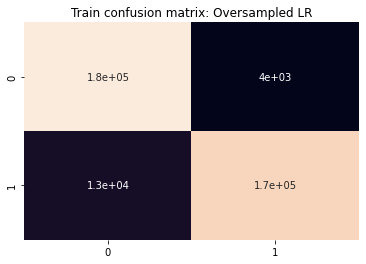

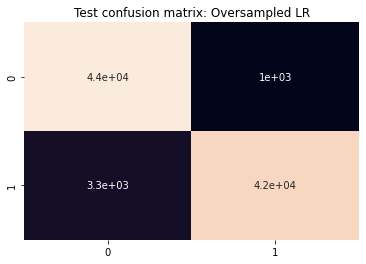


roc auc score train 0.9516705599089704


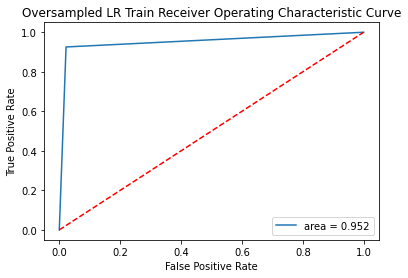


roc auc score test 0.9521905119277454


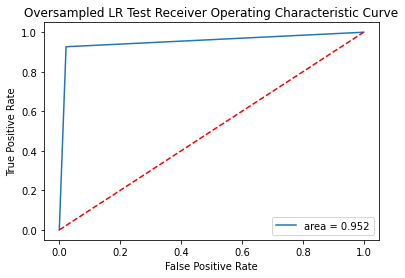


Test accuracy score 0.9770373231276992 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.88      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962


Completed for Oversampled LR
Saving model as Oversampled LR.pkl


In [ ]:
lr_ovr = LogisticRegression(class_weight= 'balanced', solver= 'liblinear')
lr_params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2", "none"]}

buildModel(lr_ovr, lr_params, x_ovr_train, y_ovr_train, x_ovr_test, y_ovr_test, test_X, test_y, 'Oversampled LR')

Oversampled logistic regression gave better performance than naive bayes, but not svc.

##### Logistic Regression with undersampled data

Building model Undersampled LR.......


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



Best score  0.9471951318150978
Best param  {'C': 0.1, 'penalty': 'l2'}
Best model  LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')

Model performance Undersampled LR

accuracy score train 0.9579646017699115
accuracy score test 0.9515418502202643

Train classification report: Undersampled LR

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       603
           1       0.95      0.92      0.94       301

    accuracy                           0.96       904
   macro avg       0.96      0.95      0.95       904
weighted avg       0.96      0.96      0.96       904


Test classification report: Undersampled LR

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       151
           1       0.95      0.91      0.93        76

    accuracy                           0.95       227
   macro avg       0.95      0.94      0.95       227
weighted avg       0.95      0.95     

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is n

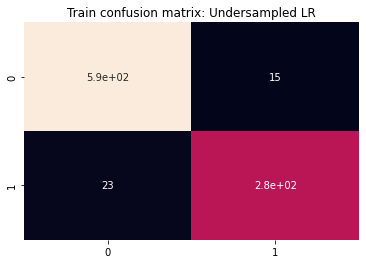

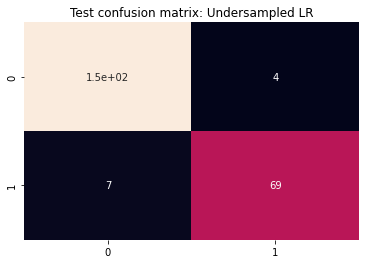


roc auc score train 0.9493562089882812


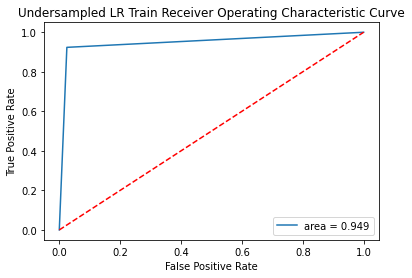


roc auc score test 0.9407023353084699


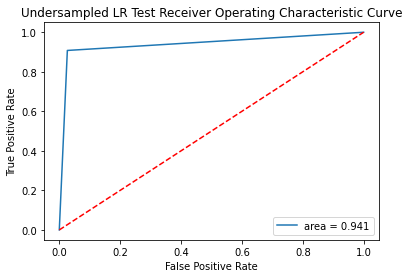


Test accuracy score 0.9765808784803904 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962


Completed for Undersampled LR
Saving model as Undersampled LR.pkl


In [ ]:
lr_udr = LogisticRegression(class_weight= 'balanced', solver= 'liblinear')
lr_params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2", "none"]}

buildModel(lr_udr, lr_params, x_udr_train, y_udr_train, x_udr_test, y_udr_test, test_X, test_y, 'Undersampled LR')

Undersampled logistic regression same similar performance as oversampled data.

#### RandomForest Classifier

##### RandomForest Classifier with oversampled data

Building model Oversampled RF.......

Best score  0.9999225664854812
Best param  {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Best model  RandomForestClassifier(class_weight='balanced', max_depth=15)

Model performance Oversampled RF

accuracy score train 0.9999502213766002
accuracy score test 0.9998672581055519

Train classification report: Oversampled RF

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       1.00      1.00      1.00    180801

    accuracy                           1.00    361601
   macro avg       1.00      1.00      1.00    361601
weighted avg       1.00      1.00      1.00    361601


Test classification report: Oversampled RF

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       1.00      1.00      1.00     45200

    accuracy                           1.00     90401
   macro avg       1.00      1.0

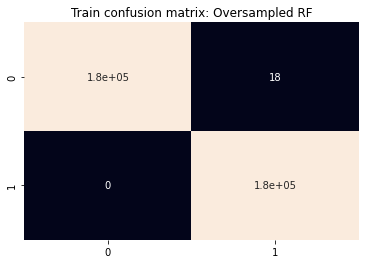

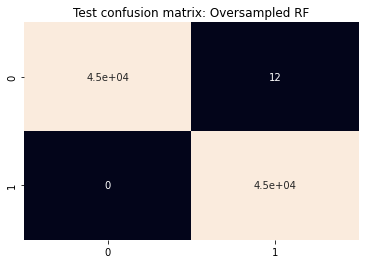


roc auc score train 0.9999502212389381


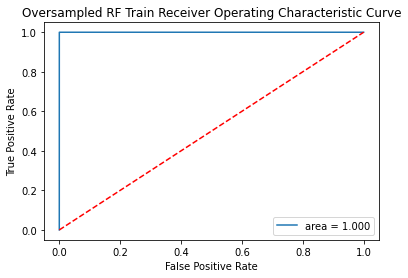


roc auc score test 0.9998672595739032


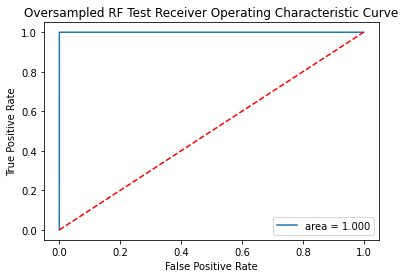


Test accuracy score 0.9994557775359011 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.79      0.83        98

    accuracy                           1.00     56962
   macro avg       0.94      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Completed for Oversampled RF
Saving model as Oversampled RF.pkl


In [246]:
rf_ovr = RandomForestClassifier(class_weight='balanced')
rf_params = {'n_estimators': [100, 150], 'max_depth': [10, 15],
'min_samples_split': [2, 4]}

buildModel(rf_ovr, rf_params, x_ovr_train, y_ovr_train, x_ovr_test, y_ovr_test, test_X, test_y, 'Oversampled RF')

RandomForest classifier with oversampled data gave the performance among all the models with significant difference.

##### RandomForest Classifier with undersampled data

Building model Undersampled RF.......

Best score  0.9500027939245086
Best param  {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 100}
Best model  RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=4)

Model performance Undersampled RF

accuracy score train 0.9944690265486725
accuracy score test 0.9515418502202643

Train classification report: Undersampled RF

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       603
           1       1.00      0.98      0.99       301

    accuracy                           0.99       904
   macro avg       1.00      0.99      0.99       904
weighted avg       0.99      0.99      0.99       904


Test classification report: Undersampled RF

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       151
           1       0.97      0.88      0.92        76

    accuracy                          

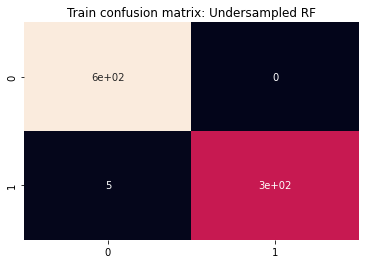

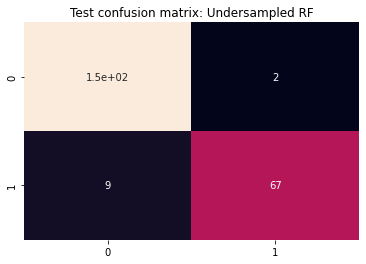


roc auc score train 0.9916943521594684


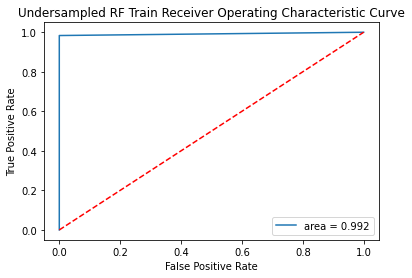


roc auc score test 0.9341669571279192


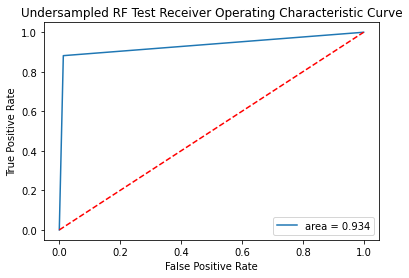


Test accuracy score 0.9913275517011341 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.15      0.86      0.25        98

    accuracy                           0.99     56962
   macro avg       0.57      0.92      0.62     56962
weighted avg       1.00      0.99      0.99     56962


Completed for Undersampled RF
Saving model as Undersampled RF.pkl


In [ ]:
rf_udr = RandomForestClassifier(class_weight='balanced')
rf_params = {'n_estimators': [100, 150], 'max_depth': [10, 15],
'min_samples_split': [2, 4]}

buildModel(rf_udr, rf_params, x_udr_train, y_udr_train, x_udr_test, y_udr_test, test_X, test_y, 'Undersampled RF')

Random forest with undersampled data gave better performance than the other models. but its less as compared to the same with oversampled data. Thats why its always good to try an ensamble technique.



#### XGBoost Classifier

##### XGBClassifier with oversampled data

Building model Oversampled XGBC.......

Best score  0.9999087390899989
Best param  {'gamma': 0.05, 'max_depth': 10, 'n_estimators': 150}
Best model  XGBClassifier(gamma=0.05, max_depth=10, n_estimators=150)

Model performance Oversampled XGBC

accuracy score train 1.0
accuracy score test 0.9999225672282386

Train classification report: Oversampled XGBC

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       1.00      1.00      1.00    180801

    accuracy                           1.00    361601
   macro avg       1.00      1.00      1.00    361601
weighted avg       1.00      1.00      1.00    361601


Test classification report: Oversampled XGBC

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       1.00      1.00      1.00     45200

    accuracy                           1.00     90401
   macro avg       1.00      1.00      1.00     9040

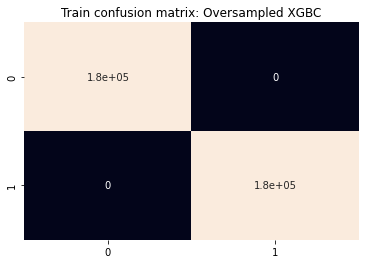

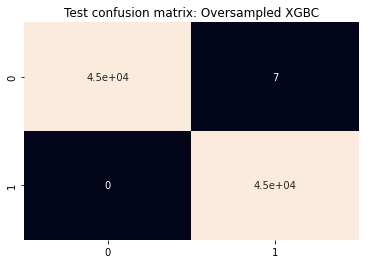


roc auc score train 1.0


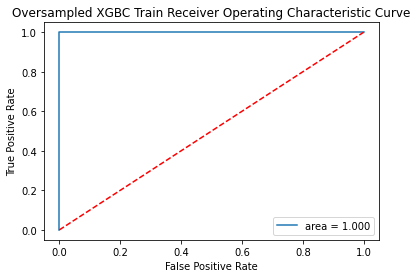


roc auc score test 0.9999225680847769


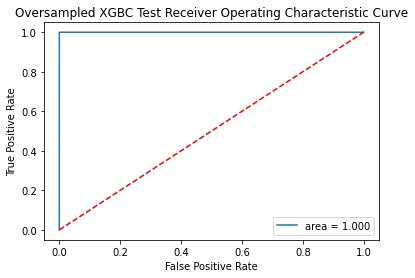


Test accuracy score 0.999403110845827 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.79      0.82        98

    accuracy                           1.00     56962
   macro avg       0.93      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Completed for Oversampled XGBC
Saving model as Oversampled XGBC.pkl


In [ ]:
xgbc_ovr = XGBClassifier(objective='binary:logistic')
xgbc_params = {
"gamma": [0.05, 0.1], "max_depth": [10, 15],
"n_estimators": [120, 150]
}

buildModel(xgbc_ovr, xgbc_params, x_ovr_train, y_ovr_train, x_ovr_test, y_ovr_test, test_X, test_y, 'Oversampled XGBC')

XGBClassifier with oversampled data performed so well that its similar to random forest.

With all there performances, we can see how ensable techniques with proper data can give significant better performance than the other models.

##### XGBClassifier with undersampled data

Building model Undersampled XGBC.......

Best score  0.9517150786855014
Best param  {'gamma': 0.01, 'max_depth': 10, 'n_estimators': 150}
Best model  XGBClassifier(gamma=0.01, max_depth=10, n_estimators=150)

Model performance Undersampled XGBC

accuracy score train 1.0
accuracy score test 0.9559471365638766

Train classification report: Undersampled XGBC

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       603
           1       1.00      1.00      1.00       301

    accuracy                           1.00       904
   macro avg       1.00      1.00      1.00       904
weighted avg       1.00      1.00      1.00       904


Test classification report: Undersampled XGBC

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       151
           1       0.97      0.89      0.93        76

    accuracy                           0.96       227
   macro avg       0.96      0.94      0.95     

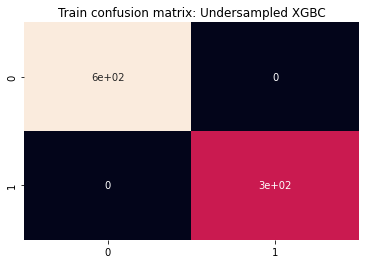

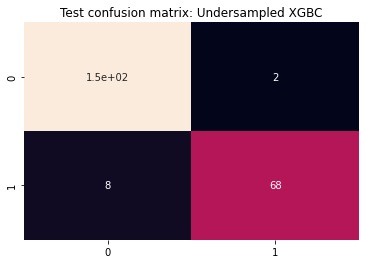


roc auc score train 1.0


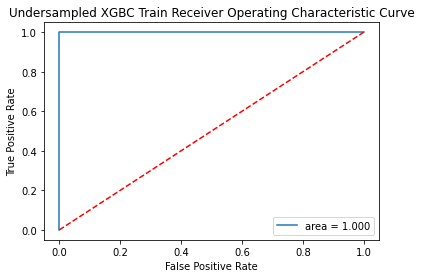


roc auc score test 0.9407459044963403


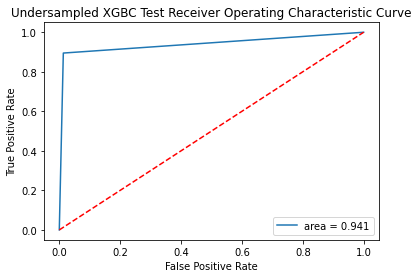


Test accuracy score 0.9878515501562445 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.86      0.20        98

    accuracy                           0.99     56962
   macro avg       0.55      0.92      0.59     56962
weighted avg       1.00      0.99      0.99     56962


Completed for Undersampled XGBC
Saving model as Undersampled XGBC.pkl


In [ ]:
xgbc_udr = XGBClassifier(objective='binary:logistic')
xgbc_params = {
"gamma": [0.01, 0.05, 0.1], "max_depth": [5, 10, 15],
"n_estimators": [100, 120, 150]
}

buildModel(xgbc_udr, xgbc_params, x_udr_train, y_udr_train, x_udr_test, y_udr_test, test_X, test_y, 'Undersampled XGBC')

XGBClassifier with undersampled data performed better than other models, but its less than random forest classifier and its oversampled version.

For models like Logistic regression, random forest and xgboost, performed better wwith the oversampled data.

SVC model gave better performance with undersampled data, where as naive bayes gave almost similar performance.

So we have random forest with oversampled data gave the highest performance in terms of f1-score (0.92) on test data.

SVC with undersampled data gave the lowest performance.

Other models with different combination of data, gave moderate performance.

So we can consider Random forest with oversampled data as our final ML model.

#### Final ML Model (Random Forest with Oversampled data)

Lets upload the random forest model from the pickle file and try to get top 10 important features from it.

In [373]:
train_udr_df = pd.read_pickle('finance_udr_train.pkl')

In [374]:
rf_ovr = pickle.load(open('Oversampled RF.pkl', 'rb'))

In [375]:
train_udr_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


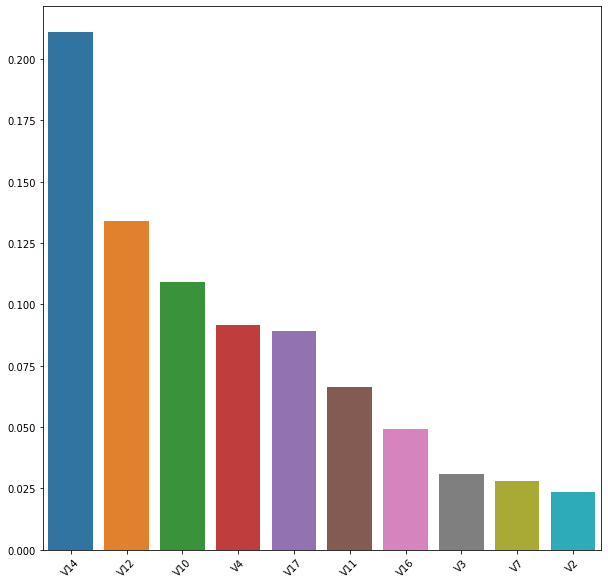

In [376]:
feature_names = train_udr_df.columns[:-1]
importances = rf_ovr.feature_importances_
important_features = np.argsort(importances)[::-1][:10]
names = feature_names[important_features]
values = importances[important_features]
plt.figure(figsize=(10,10))
sns.barplot(names, values)
plt.xticks(rotation=45)
plt.show()

Out of all the PCA transformed features, above are the most important features as per random forest model.

Unfortunately, we dont see amount and time here. So its possible that time and amount dont have close relationship with the class labels.

## Project Task: Week 2

### Applying ANN

For this binary classification problem, we can try out different ANN models where we can experiment with the number of layers, number of neurons, activation function, kernel initializers, regularizers, batch size, number of epochs, optimizers etc.

So, we can randomly experiment by selecting different combination and can build 6 models and finally we can pick the best model.

In [175]:
def buildANN(num_layer, num_neuron, activation_fn, initializer, regularizers, optimizerName, batch_size, epochs, name, dropOut= None):
  input = Input(x_train.shape[-1],)
  x = input
  nu_num = num_neuron
  for i in range(num_layer):
    x = Dense(units = nu_num, activation = activation_fn, 
              kernel_initializer = initializer, kernel_regularizer = regularizers)(x)
    nu_num //= 2
  if dropOut is not None:
    x = Dropout(dropOut)(x)
    x = BatchNormalization()(x)

  x = Dense(units = 10, activation = activation_fn, 
              kernel_initializer = initializer, kernel_regularizer = regularizers)(x)
  output = Dense(2, activation = 'softmax')(x)

  model = Model(input, output)
  print(model.summary())
  model.compile(loss='categorical_crossentropy', optimizer= optimizerName, metrics=[F1Score(num_classes= 2, average= 'macro')])
  callback = EarlyStopping(monitor='val_loss', patience=3)
  model.fit(x_train, y_train, 
                validation_data=(x_test, y_test), batch_size= batch_size, epochs=epochs, callbacks=[callback])
  
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  y_train_label = np.argmax(y_train, axis= 1)
  y_train_pred = np.argmax(y_train_pred, axis= 1)
  y_test_label = np.argmax(y_test, axis= 1)
  y_test_pred = np.argmax(y_test_pred, axis= 1)

  getPerformance(y_train_label, y_train_pred, y_test_label, y_test_pred, name)
  
  test_y_pred = model.predict(test_X)
  test_y_label = np.argmax(test_y, axis= 1)
  test_y_pred = np.argmax(test_y_pred, axis= 1)

  print('\nTest accuracy score {} \n'.format(accuracy_score(test_y_label, test_y_pred)))
  print('Classification report\n')
  print(classification_report(test_y_label, test_y_pred))
  print('\nCompleted and saved for model ' + name)
  model.save(name)

##### Oversampled data

In [163]:
finance_ovr_train = pd.read_pickle('finance_ovr_train.pkl')
finance_test = pd.read_pickle('finance_test.pkl')

In [164]:
train_ovr_X = finance_ovr_train.drop(['Class'], axis=1)
train_ovr_y = finance_ovr_train[['Class']]

test_X = finance_test.drop(['Class'], axis=1)
test_y = finance_test[['Class']]

In [165]:
x_train, x_test, y_train, y_test = train_test_split(train_ovr_X, train_ovr_y, 
                                                                     stratify= train_ovr_y,
                                                                     test_size= 0.2, random_state= 0)

In [166]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
test_y = to_categorical(test_y)

In [167]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(test_X.shape)
print(test_y.shape)

(361601, 30)
(361601, 2)
(90401, 30)
(90401, 2)
(56962, 30)
(56962, 2)


#### ANN with oversampled data

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_130 (Dense)           (None, 32)                992       
                                                                 
 dense_131 (Dense)           (None, 10)                330       
                                                                 
 dense_132 (Dense)           (None, 2)                 22        
                                                                 
Total params: 1,344
Trainable params: 1,344
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
12054/12054 [==============================] - 26s 2ms/step - loss: 0.3099 - f1_score: 0.9580 - val_loss: 0.1203 - val_f1_score: 0.9738
Epoch 2/5
12054/12054 [==============

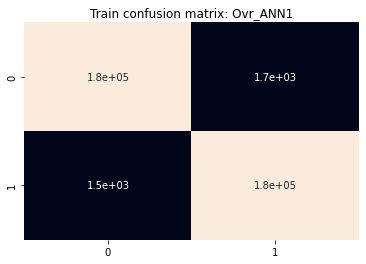

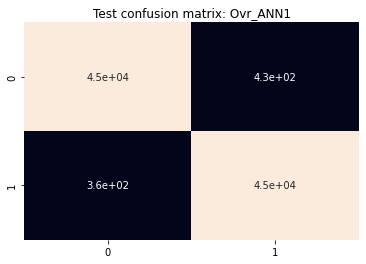


roc auc score train 0.9911919473093994


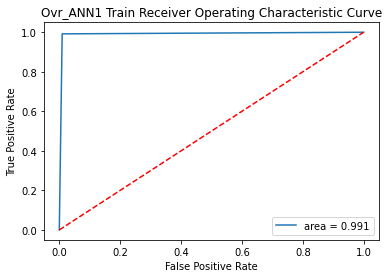


roc auc score test 0.9912832918078991


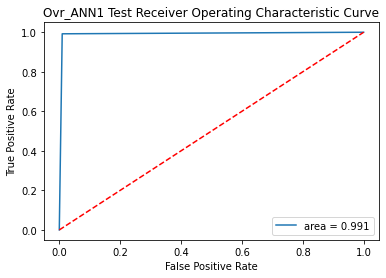

1781/1781 [==============================] - 2s 1ms/step

Test accuracy score 0.9896773287454794 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.89      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Ovr_ANN1


In [176]:
buildANN(1, 32, 'relu', 'he_normal', 'l2', 'sgd', 30, 5, 'Ovr_ANN1')

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_133 (Dense)           (None, 32)                992       
                                                                 
 dense_134 (Dense)           (None, 16)                528       
                                                                 
 dense_135 (Dense)           (None, 10)                170       
                                                                 
 dense_136 (Dense)           (None, 2)                 22        
                                                                 
Total params: 1,712
Trainable params: 1,712
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
12054/12054 [============================

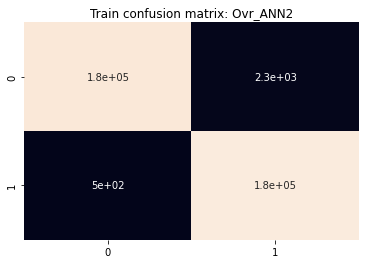

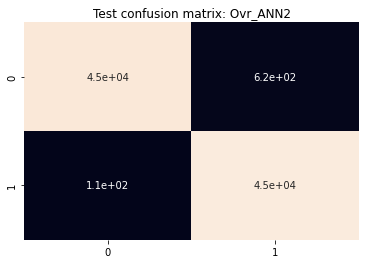


roc auc score train 0.9921958041386431


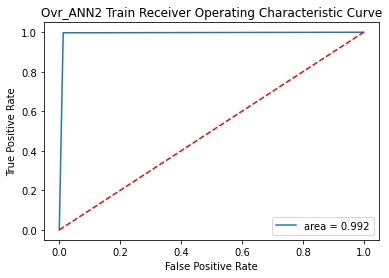


roc auc score test 0.9919802399821603


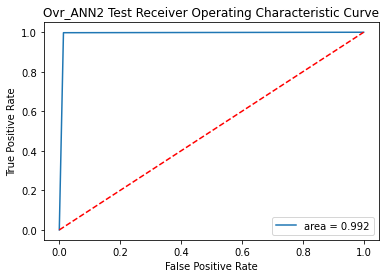

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9861311049471577 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.91      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Ovr_ANN2


In [177]:
buildANN(2, 32, 'relu', 'he_normal', 'l2', 'sgd', 30, 5, 'Ovr_ANN2')

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_137 (Dense)           (None, 128)               3968      
                                                                 
 dense_138 (Dense)           (None, 64)                8256      
                                                                 
 dense_139 (Dense)           (None, 10)                650       
                                                                 
 dense_140 (Dense)           (None, 2)                 22        
                                                                 
Total params: 12,896
Trainable params: 12,896
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
12054/12054 [=========================

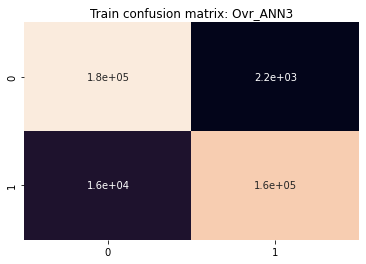

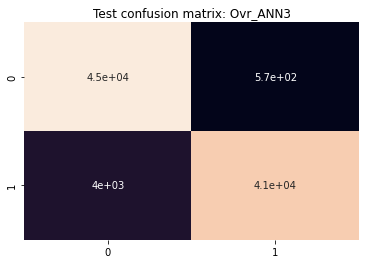


roc auc score train 0.9486866432789769


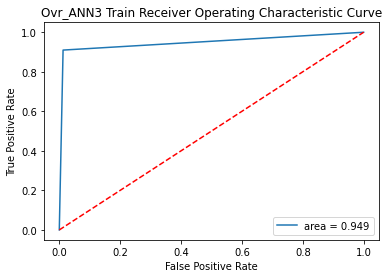


roc auc score test 0.9489271311348152


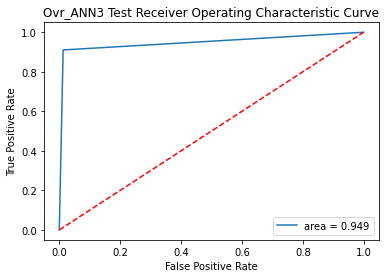

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9870088831150592 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.87      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Ovr_ANN3


In [178]:
buildANN(2, 128, 'relu', 'he_normal', 'l1', 'sgd', 30, 10, 'Ovr_ANN3')

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_141 (Dense)           (None, 128)               3968      
                                                                 
 dense_142 (Dense)           (None, 64)                8256      
                                                                 
 dense_143 (Dense)           (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_9 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                          

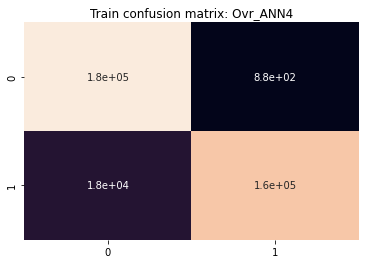

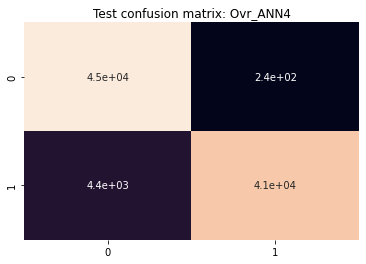


roc auc score train 0.9486037000147769


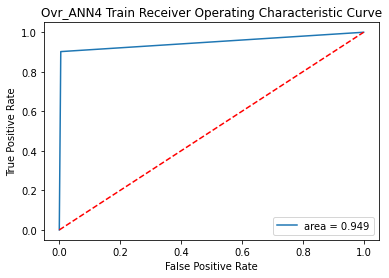


roc auc score test 0.9485730683184431


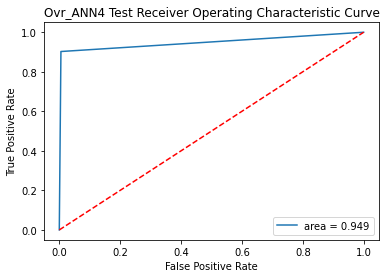

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9945928864857273 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.86      0.35        98

    accuracy                           0.99     56962
   macro avg       0.61      0.93      0.68     56962
weighted avg       1.00      0.99      1.00     56962


Completed and saved for model Ovr_ANN4


In [179]:
buildANN(3, 128, 'relu', 'he_normal', 'l1', 'sgd', 30, 10, 'Ovr_ANN4', 0.2)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_146 (Dense)           (None, 128)               3968      
                                                                 
 dense_147 (Dense)           (None, 64)                8256      
                                                                 
 dense_148 (Dense)           (None, 32)                2080      
                                                                 
 dense_149 (Dense)           (None, 10)                330       
                                                                 
 dense_150 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

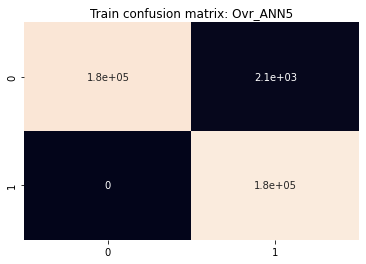

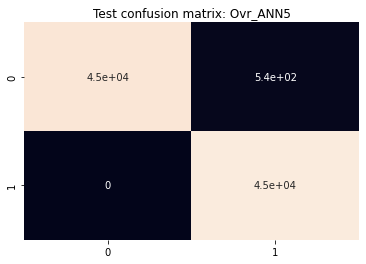


roc auc score train 0.9940569690265486


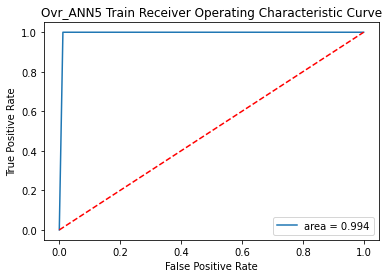


roc auc score test 0.994004557421296


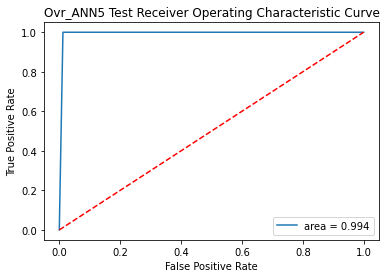

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9876057722692321 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.87      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Ovr_ANN5


In [180]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'rmsprop', 30, 10, 'Ovr_ANN5')

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_151 (Dense)           (None, 128)               3968      
                                                                 
 dense_152 (Dense)           (None, 64)                8256      
                                                                 
 dense_153 (Dense)           (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_10 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                          

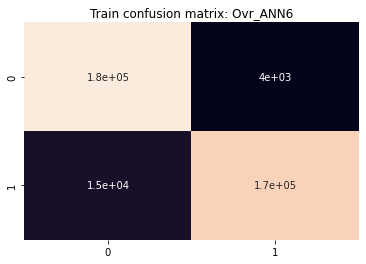

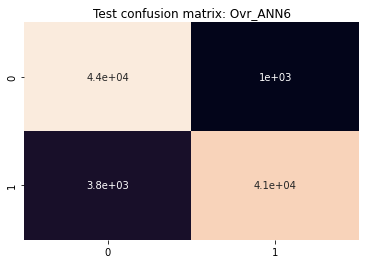


roc auc score train 0.9466014517262733


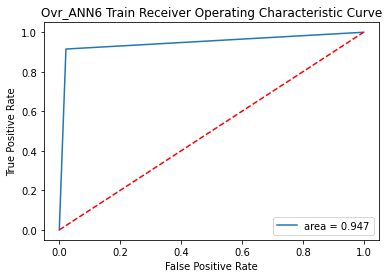


roc auc score test 0.9470356493209388


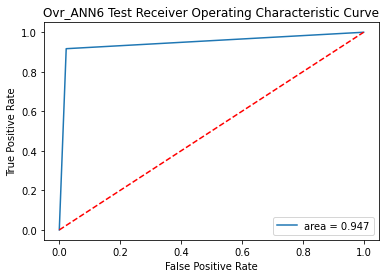

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9779853235490327 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962


Completed and saved for model Ovr_ANN6


In [181]:
buildANN(3, 128, 'relu', 'he_uniform', 'l1', 'adadelta', 30, 10, 'Ovr_ANN6', 0.2)

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_156 (Dense)           (None, 128)               3968      
                                                                 
 dense_157 (Dense)           (None, 64)                8256      
                                                                 
 dense_158 (Dense)           (None, 32)                2080      
                                                                 
 dense_159 (Dense)           (None, 16)                528       
                                                                 
 dense_160 (Dense)           (None, 10)                170       
                                                                 
 dense_161 (Dense)           (None, 2)                 22 

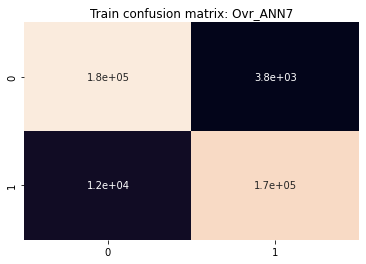

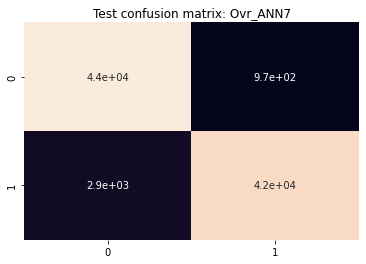


roc auc score train 0.9574974113015419


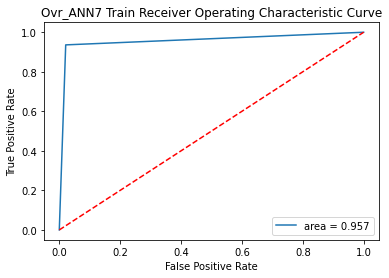


roc auc score test 0.9576882895045199


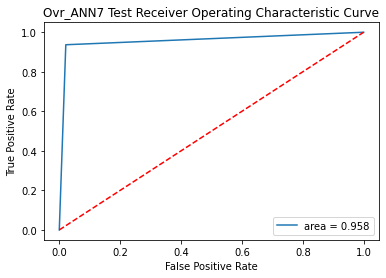

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9782486569994031 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.89      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962


Completed and saved for model Ovr_ANN7


In [182]:
buildANN(4, 128, 'tanh', 'he_uniform', 'l2', 'adagrad', 20, 10, 'Ovr_ANN7')

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_162 (Dense)           (None, 128)               3968      
                                                                 
 dense_163 (Dense)           (None, 64)                8256      
                                                                 
 dense_164 (Dense)           (None, 32)                2080      
                                                                 
 dense_165 (Dense)           (None, 16)                528       
                                                                 
 dense_166 (Dense)           (None, 10)                170       
                                                                 
 dense_167 (Dense)           (None, 2)                 22 

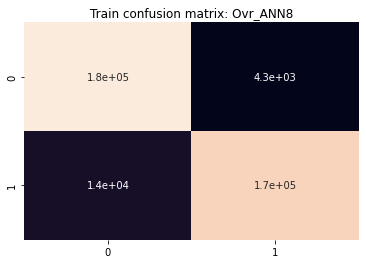

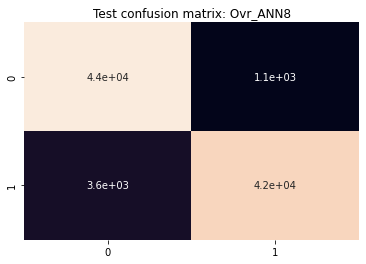


roc auc score train 0.9483381629049158


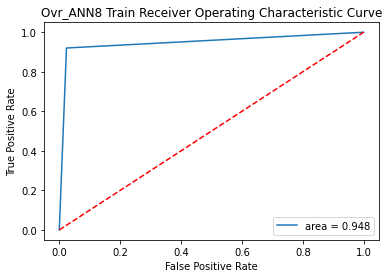


roc auc score test 0.948761322582142


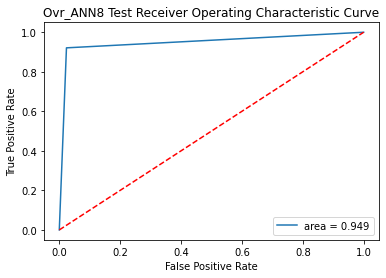

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9761771005231558 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.88      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962


Completed and saved for model Ovr_ANN8


In [183]:
buildANN(4, 128, 'relu', 'he_normal', 'l1', 'adam', 40, 10, 'Ovr_ANN8')

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_168 (Dense)           (None, 256)               7936      
                                                                 
 dense_169 (Dense)           (None, 128)               32896     
                                                                 
 dense_170 (Dense)           (None, 64)                8256      
                                                                 
 dense_171 (Dense)           (None, 32)                2080      
                                                                 
 dense_172 (Dense)           (None, 10)                330       
                                                                 
 dense_173 (Dense)           (None, 2)                 22 

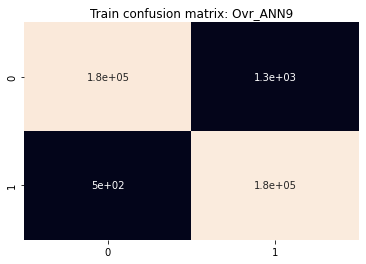

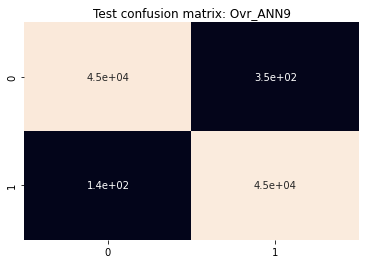


roc auc score train 0.9951299854780935


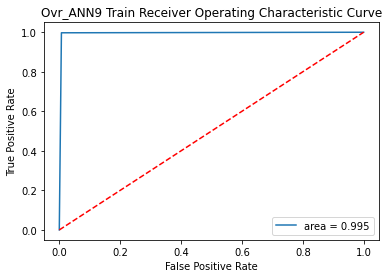


roc auc score test 0.9945797324066564


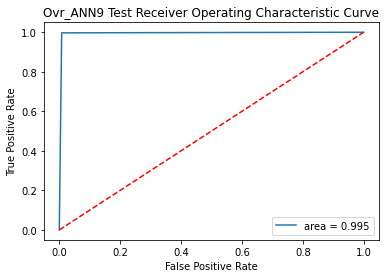

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9923106632491837 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.17      0.88      0.28        98

    accuracy                           0.99     56962
   macro avg       0.58      0.94      0.64     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Ovr_ANN9


In [184]:
buildANN(4, 256, 'relu', 'he_normal', 'l2', 'adam', 30, 10, 'Ovr_ANN9')

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_174 (Dense)           (None, 256)               7936      
                                                                 
 dense_175 (Dense)           (None, 128)               32896     
                                                                 
 dense_176 (Dense)           (None, 64)                8256      
                                                                 
 dense_177 (Dense)           (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128

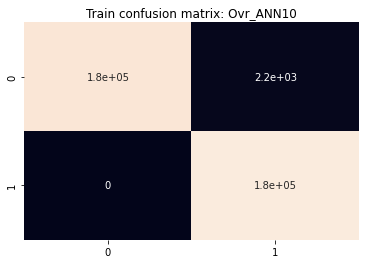

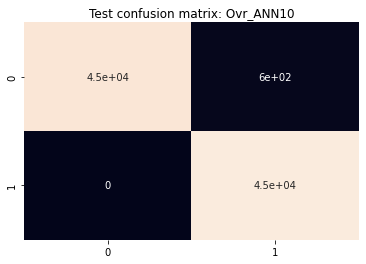


roc auc score train 0.9938080752212389


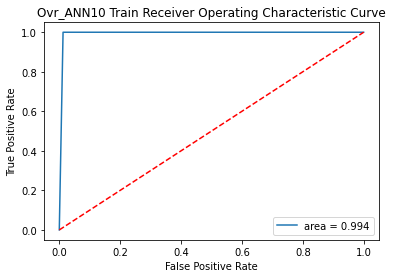


roc auc score test 0.9933629786951615


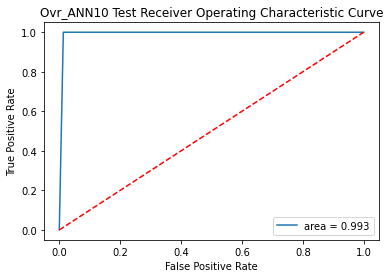

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9870088831150592 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.88      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Ovr_ANN10


In [185]:
buildANN(4, 256, 'relu', 'he_normal', 'l2', 'adam', 30, 10, 'Ovr_ANN10', 0.3)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_180 (Dense)           (None, 128)               3968      
                                                                 
 dense_181 (Dense)           (None, 64)                8256      
                                                                 
 dense_182 (Dense)           (None, 32)                2080      
                                                                 
 dense_183 (Dense)           (None, 10)                330       
                                                                 
 dense_184 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

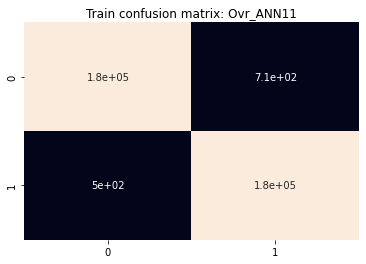

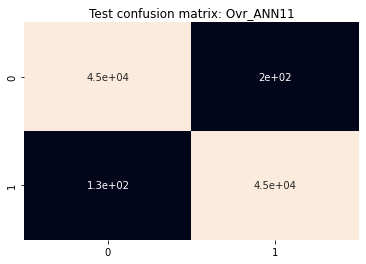


roc auc score train 0.9966675961128583


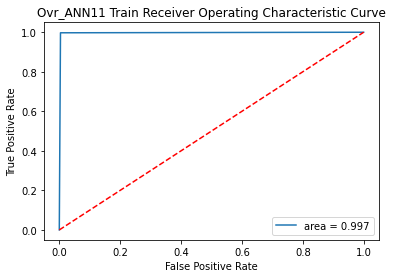


roc auc score test 0.9963938530316798


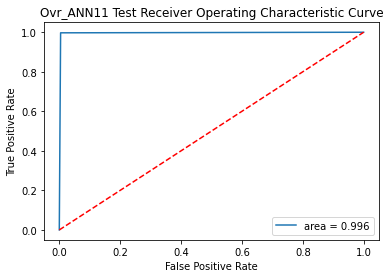

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9957339981039992 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.27      0.88      0.41        98

    accuracy                           1.00     56962
   macro avg       0.64      0.94      0.71     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model Ovr_ANN11


In [186]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'adam', 30, 10, 'Ovr_ANN11')

We can select the model that gave higher macro f1-score on the test data. Model Ovr_ANN11 gave the best result till now (F1score macro= 0.71). So the number of layers and number of neurons mostly matters. Also its the optimizer that helps to get better performance.

So till now get the best result with 3 layers, (128, 64, 32) neurons respectively, relu acrivation, he_normal kernel initializer, l2 regularizer, adam optimizer, 30 batch size, 10 eochs.

The number of neurons also should be suitable for the input dimension.

Now we can try few models with undersamled data.

##### Undersampled data

In [187]:
finance_udr_train = pd.read_pickle('finance_udr_train.pkl')
finance_test = pd.read_pickle('finance_test.pkl')

In [188]:
train_udr_X = finance_udr_train.drop(['Class'], axis=1)
train_udr_y = finance_udr_train[['Class']]

test_X = finance_test.drop(['Class'], axis=1)
test_y = finance_test[['Class']]

In [189]:
x_train, x_test, y_train, y_test = train_test_split(train_udr_X, train_udr_y, 
                                                                     stratify= train_udr_y,
                                                                     test_size= 0.2, random_state= 0)

In [190]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
test_y = to_categorical(test_y)

In [191]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(test_X.shape)
print(test_y.shape)

(904, 30)
(904, 2)
(227, 30)
(227, 2)
(56962, 30)
(56962, 2)


#### ANN with undersampled data

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_185 (Dense)           (None, 128)               3968      
                                                                 
 dense_186 (Dense)           (None, 64)                8256      
                                                                 
 dense_187 (Dense)           (None, 32)                2080      
                                                                 
 dense_188 (Dense)           (None, 10)                330       
                                                                 
 dense_189 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

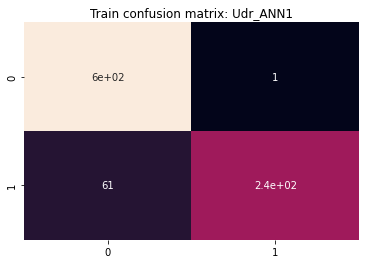

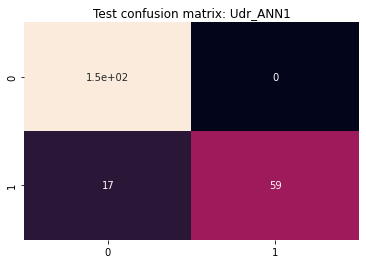


roc auc score train 0.8978419089491633


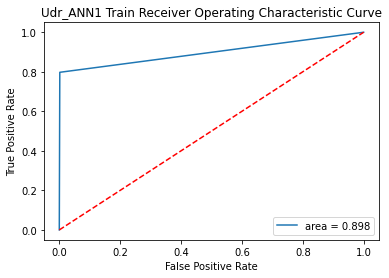


roc auc score test 0.888157894736842


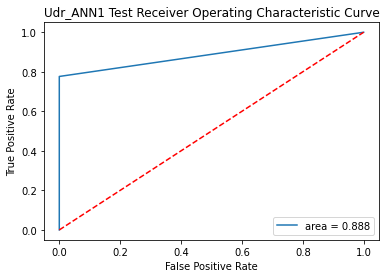

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9979284435237527 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.44      0.71      0.54        98

    accuracy                           1.00     56962
   macro avg       0.72      0.86      0.77     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model Udr_ANN1


In [192]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'sgd', 30, 10, 'Udr_ANN1')

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_190 (Dense)           (None, 128)               3968      
                                                                 
 dense_191 (Dense)           (None, 64)                8256      
                                                                 
 dense_192 (Dense)           (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_12 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                          

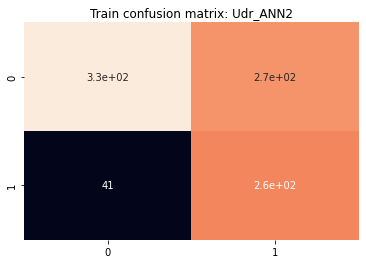

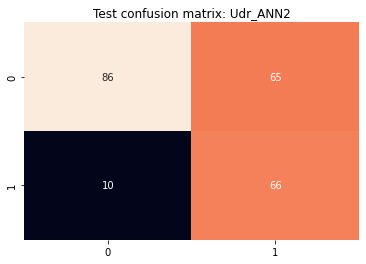


roc auc score train 0.7088422780890673


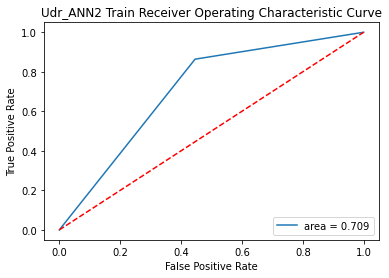


roc auc score test 0.7189787382363193


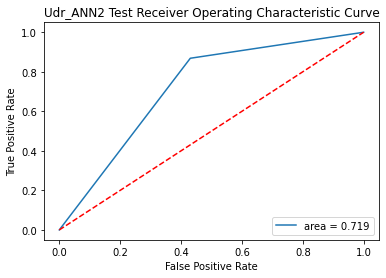

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.5401320178364524 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.54      0.70     56864
           1       0.00      0.83      0.01        98

    accuracy                           0.54     56962
   macro avg       0.50      0.68      0.35     56962
weighted avg       1.00      0.54      0.70     56962


Completed and saved for model Udr_ANN2


In [193]:
buildANN(3, 128, 'relu', 'he_uniform', 'l2', 'adadelta', 30, 10, 'Udr_ANN2', 0.2)

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_195 (Dense)           (None, 128)               3968      
                                                                 
 dense_196 (Dense)           (None, 64)                8256      
                                                                 
 dense_197 (Dense)           (None, 32)                2080      
                                                                 
 dense_198 (Dense)           (None, 10)                330       
                                                                 
 dense_199 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

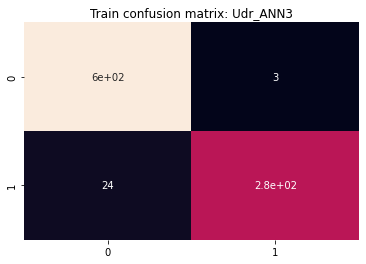

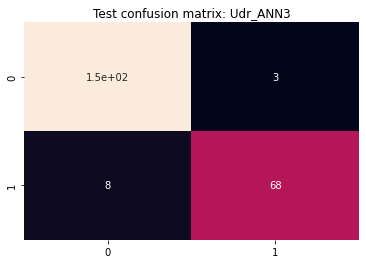


roc auc score train 0.9576453281763938


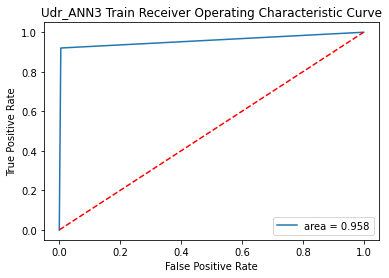


roc auc score test 0.9374346462181945


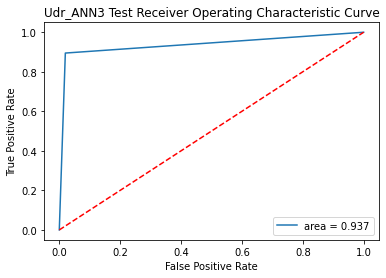

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9858151048067132 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.87      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.58     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Udr_ANN3


In [194]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'rmsprop', 30, 10, 'Udr_ANN3')

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_200 (Dense)           (None, 128)               3968      
                                                                 
 dense_201 (Dense)           (None, 64)                8256      
                                                                 
 dense_202 (Dense)           (None, 32)                2080      
                                                                 
 dense_203 (Dense)           (None, 10)                330       
                                                                 
 dense_204 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

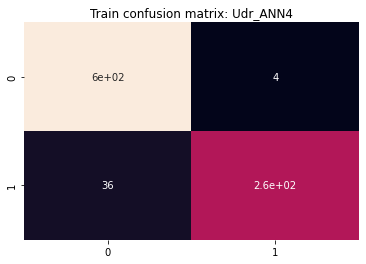

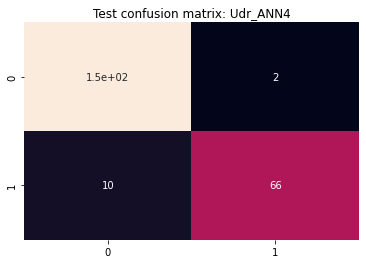


roc auc score train 0.9368825859627665


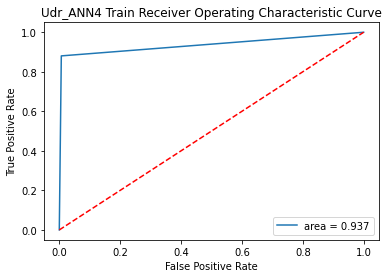


roc auc score test 0.9275880097594982


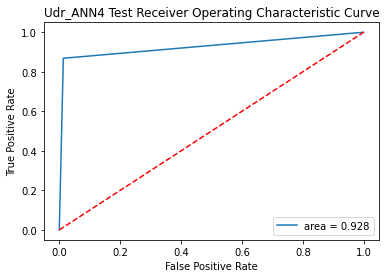

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9876584389593062 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.84      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.91      0.59     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Udr_ANN4


In [195]:
buildANN(3, 128, 'relu', 'he_normal', 'l1', 'rmsprop', 40, 10, 'Udr_ANN4')

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_205 (Dense)           (None, 128)               3968      
                                                                 
 dense_206 (Dense)           (None, 64)                8256      
                                                                 
 dense_207 (Dense)           (None, 32)                2080      
                                                                 
 dense_208 (Dense)           (None, 10)                330       
                                                                 
 dense_209 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

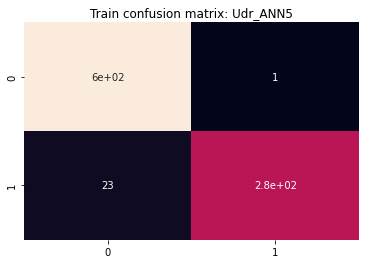

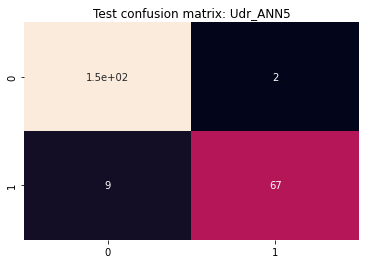


roc auc score train 0.9609648325372033


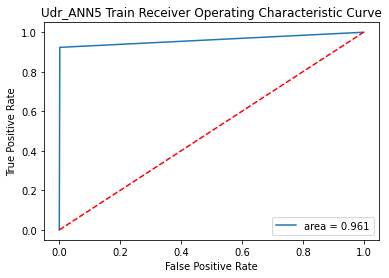


roc auc score test 0.9341669571279192


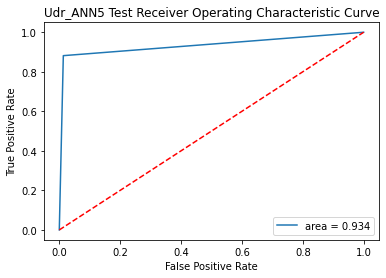

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9893086619149608 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.87      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.93      0.61     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Udr_ANN5


In [196]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'adam', 30, 10, 'Udr_ANN5')

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_210 (Dense)           (None, 128)               3968      
                                                                 
 dense_211 (Dense)           (None, 64)                8256      
                                                                 
 dense_212 (Dense)           (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_13 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                          

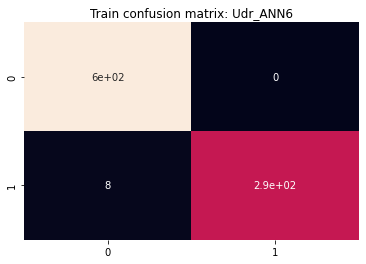

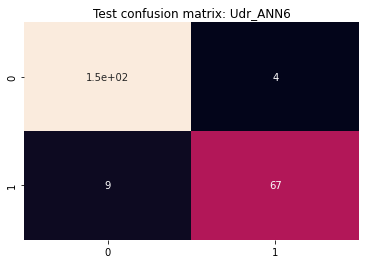


roc auc score train 0.9867109634551495


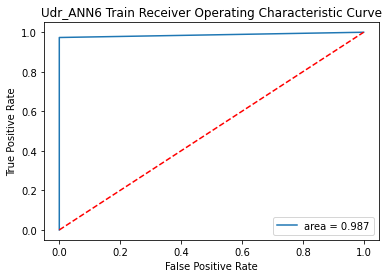


roc auc score test 0.9275444405716278


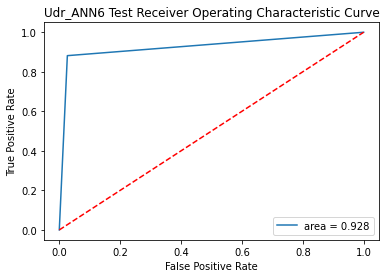

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9871142164952074 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.88      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Udr_ANN6


In [197]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'adam', 40, 20, 'Udr_ANN6', 0.2)

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_215 (Dense)           (None, 128)               3968      
                                                                 
 dense_216 (Dense)           (None, 64)                8256      
                                                                 
 dense_217 (Dense)           (None, 32)                2080      
                                                                 
 dense_218 (Dense)           (None, 16)                528       
                                                                 
 dense_219 (Dense)           (None, 10)                170       
                                                                 
 dense_220 (Dense)           (None, 2)                 22 

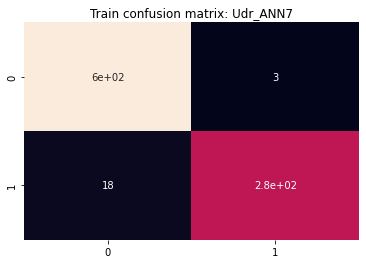

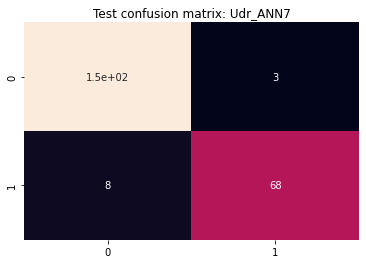


roc auc score train 0.9676121055850317


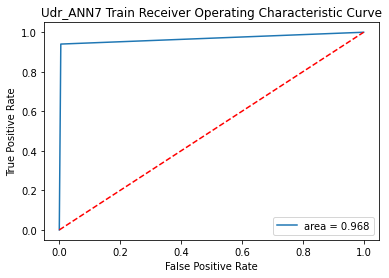


roc auc score test 0.9374346462181945


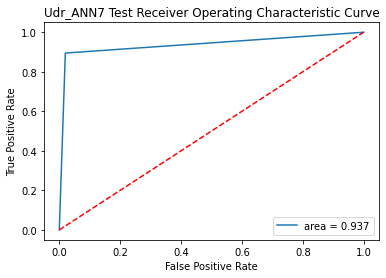

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9850777711456761 

Classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.87      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.58     56962
weighted avg       1.00      0.99      0.99     56962


Completed and saved for model Udr_ANN7


In [198]:
buildANN(4, 128, 'relu', 'he_normal', 'l2', 'adam', 30, 10, 'Udr_ANN7')

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_221 (Dense)           (None, 256)               7936      
                                                                 
 dense_222 (Dense)           (None, 128)               32896     
                                                                 
 dense_223 (Dense)           (None, 64)                8256      
                                                                 
 dense_224 (Dense)           (None, 32)                2080      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_14 (Bat  (None, 32)               128

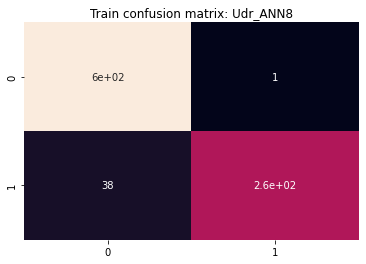

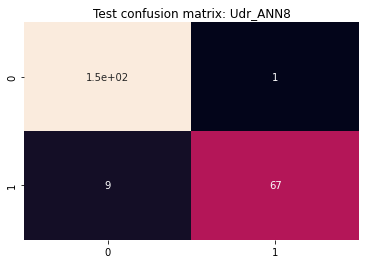


roc auc score train 0.9360478890156085


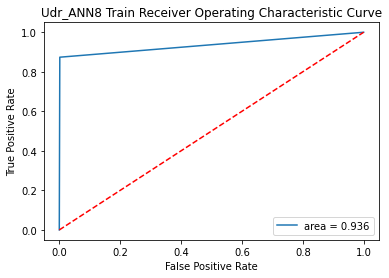


roc auc score test 0.9374782154060647


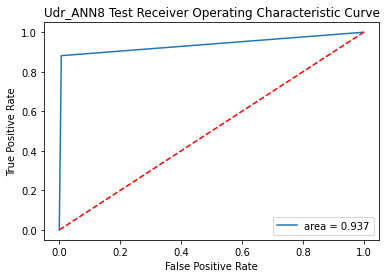

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.996892665285629 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.34      0.83      0.48        98

    accuracy                           1.00     56962
   macro avg       0.67      0.91      0.74     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model Udr_ANN8


In [199]:
buildANN(4, 256, 'relu', 'he_normal', 'l2', 'adam', 30, 10, 'Udr_ANN8', 0.2)

With undersampled data, Udr_ANN1 gave better result than the other undersampled models (f1-score macro= 0.77).

Also by comparing the performance with the oversampled models, undersampled ANN8 model gave the best performance.

So till now get the best result with 3 layers, (128, 64, 32) neurons respectively, relu acrivation, he_normal kernel initializer, l2 regularizer, sgd optimizer, 30 batch size, 10 eochs.

Further we can try with original data.

##### Original data

In [200]:
finance_train = pd.read_pickle('finance_train.pkl')
finance_test = pd.read_pickle('finance_test.pkl')

In [201]:
train_X = finance_train.drop(['Class'], axis=1)
train_y = finance_train[['Class']]

test_X = finance_test.drop(['Class'], axis=1)
test_y = finance_test[['Class']]

In [202]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, 
                                                                     stratify= train_y,
                                                                     test_size= 0.2, random_state= 0)

In [203]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
test_y = to_categorical(test_y)

In [204]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(test_X.shape)
print(test_y.shape)

(181102, 30)
(181102, 2)
(45276, 30)
(45276, 2)
(56962, 30)
(56962, 2)


#### ANN with original data

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_227 (Dense)           (None, 128)               3968      
                                                                 
 dense_228 (Dense)           (None, 64)                8256      
                                                                 
 dense_229 (Dense)           (None, 32)                2080      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_15 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                          

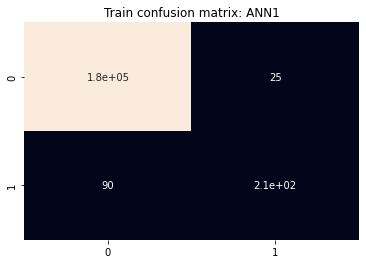

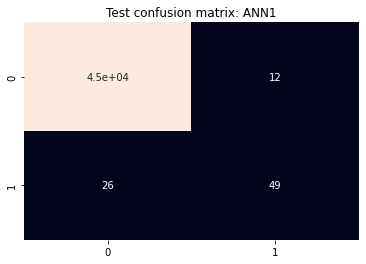


roc auc score train 0.8509242403153021


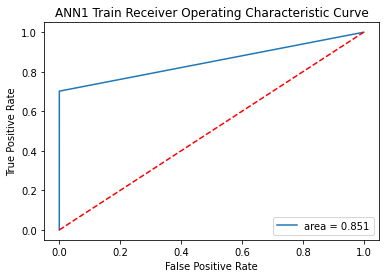


roc auc score test 0.8265339262405699


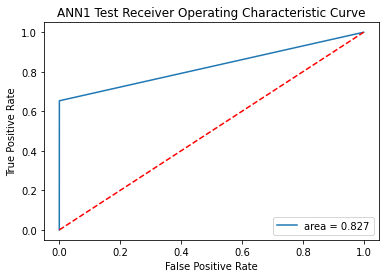

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9991924440855307 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.64      0.73        98

    accuracy                           1.00     56962
   macro avg       0.93      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model ANN1


In [205]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'sgd', 30, 10, 'ANN1', 0.2)

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_232 (Dense)           (None, 128)               3968      
                                                                 
 dense_233 (Dense)           (None, 64)                8256      
                                                                 
 dense_234 (Dense)           (None, 32)                2080      
                                                                 
 dense_235 (Dense)           (None, 10)                330       
                                                                 
 dense_236 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       0.00      0.00      0.00       302

    accuracy                           1.00    181102
   macro avg       0.50      0.50      0.50    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: ANN2

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.00      0.00      0.00        75

    accuracy                           1.00     45276
   macro avg       0.50      0.50      0.50     45276
weighted avg       1.00      1.00      1.00     45276





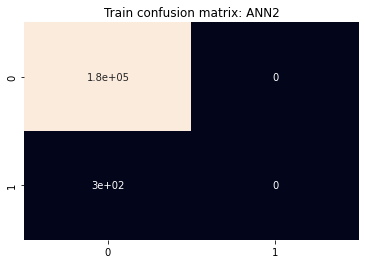

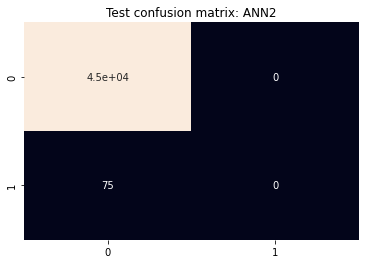


roc auc score train 0.5


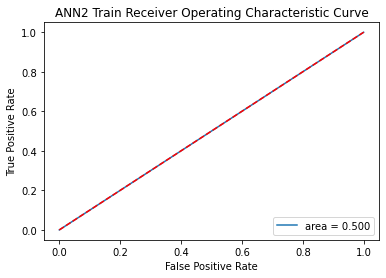


roc auc score test 0.5


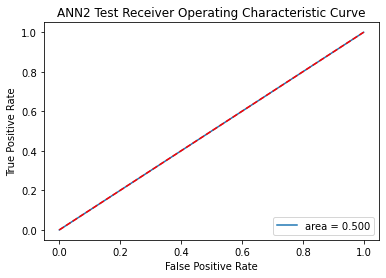

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9982795547909132 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model ANN2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [206]:
buildANN(3, 128, 'relu', 'he_uniform', 'l2', 'adadelta', 30, 10, 'ANN2')

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_237 (Dense)           (None, 64)                1984      
                                                                 
 dense_238 (Dense)           (None, 32)                2080      
                                                                 
 dense_239 (Dense)           (None, 16)                528       
                                                                 
 dense_240 (Dense)           (None, 10)                170       
                                                                 
 dense_241 (Dense)           (None, 2)                 22        
                                                                 
Total params: 4,784
Trainable params: 4,784
Non-trainable 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       0.00      0.00      0.00       302

    accuracy                           1.00    181102
   macro avg       0.50      0.50      0.50    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: ANN3

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.00      0.00      0.00        75

    accuracy                           1.00     45276
   macro avg       0.50      0.50      0.50     45276
weighted avg       1.00      1.00      1.00     45276





/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

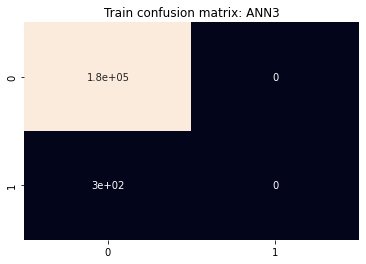

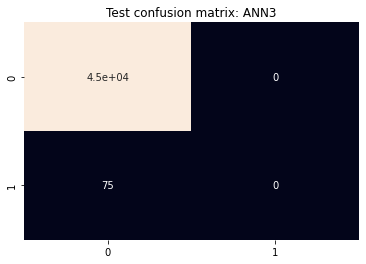


roc auc score train 0.5


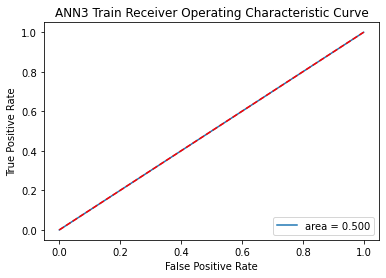


roc auc score test 0.5


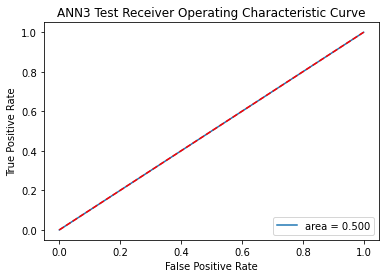

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9982795547909132 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model ANN3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [207]:
buildANN(3, 64, 'relu', 'he_normal', 'l1', 'rmsprop', 30, 10, 'ANN3')

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_242 (Dense)           (None, 128)               3968      
                                                                 
 dense_243 (Dense)           (None, 64)                8256      
                                                                 
 dense_244 (Dense)           (None, 32)                2080      
                                                                 
 dense_245 (Dense)           (None, 10)                330       
                                                                 
 dense_246 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       0.00      0.00      0.00       302

    accuracy                           1.00    181102
   macro avg       0.50      0.50      0.50    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: ANN4

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.00      0.00      0.00        75

    accuracy                           1.00     45276
   macro avg       0.50      0.50      0.50     45276
weighted avg       1.00      1.00      1.00     45276





/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


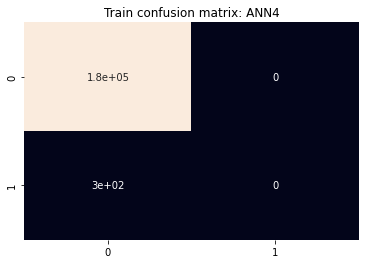

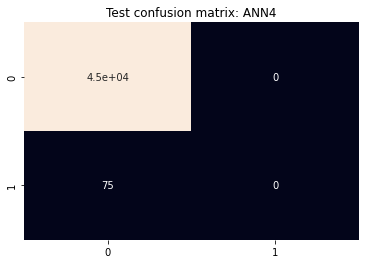


roc auc score train 0.5


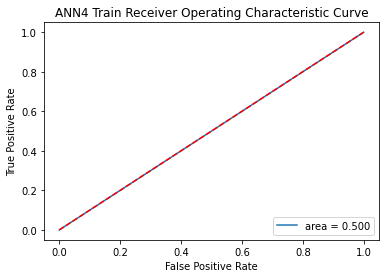


roc auc score test 0.5


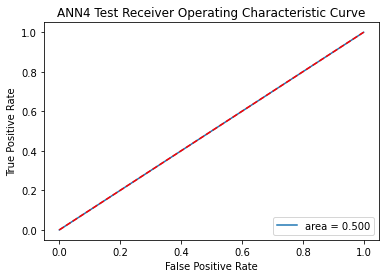

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9982795547909132 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model ANN4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [208]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'rmsprop', 30, 10, 'ANN4')

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_247 (Dense)           (None, 128)               3968      
                                                                 
 dense_248 (Dense)           (None, 64)                8256      
                                                                 
 dense_249 (Dense)           (None, 32)                2080      
                                                                 
 dense_250 (Dense)           (None, 10)                330       
                                                                 
 dense_251 (Dense)           (None, 2)                 22        
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainabl

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       0.00      0.00      0.00       302

    accuracy                           1.00    181102
   macro avg       0.50      0.50      0.50    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: ANN5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.00      0.00      0.00        75

    accuracy                           1.00     45276
   macro avg       0.50      0.50      0.50     45276
weighted avg       1.00      1.00      1.00     45276





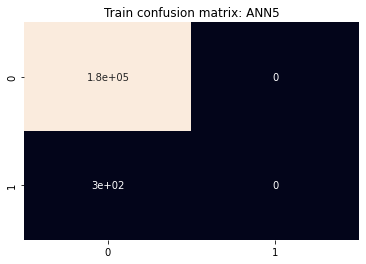

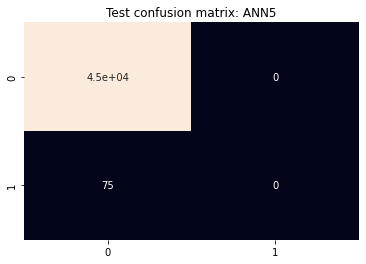


roc auc score train 0.5


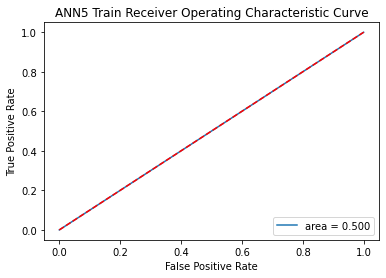


roc auc score test 0.5


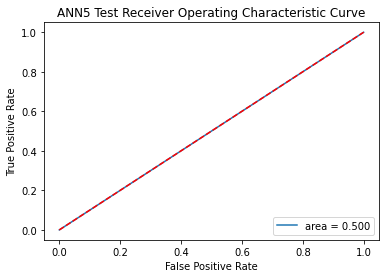

1781/1781 [==============================] - 3s 1ms/step

Test accuracy score 0.9982795547909132 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model ANN5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [209]:
buildANN(3, 128, 'relu', 'he_normal', 'l2', 'adam', 30, 20, 'ANN5')

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_252 (Dense)           (None, 256)               7936      
                                                                 
 dense_253 (Dense)           (None, 128)               32896     
                                                                 
 dense_254 (Dense)           (None, 64)                8256      
                                                                 
 dense_255 (Dense)           (None, 32)                2080      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_16 (Bat  (None, 32)               128

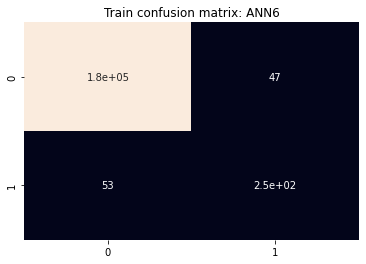

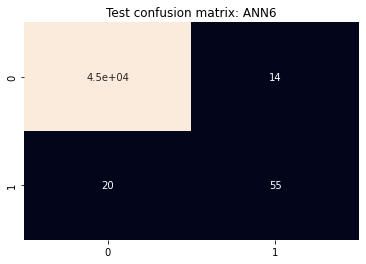


roc auc score train 0.9121216777530329


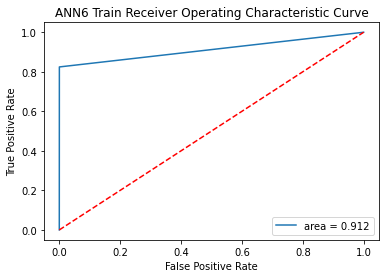


roc auc score test 0.8665118028362204


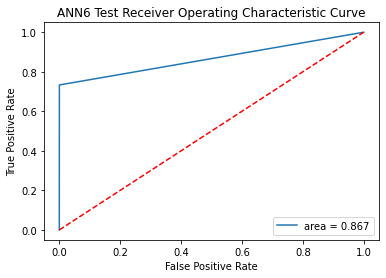

1781/1781 [==============================] - 3s 2ms/step

Test accuracy score 0.9993153330290369 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.77      0.79        98

    accuracy                           1.00     56962
   macro avg       0.91      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model ANN6


In [210]:
buildANN(4, 256, 'relu', 'he_normal', 'l2', 'adam', 30, 10, 'ANN6', 0.2)

Among all the models with oversampled, undersampled and original inputs, we got the best model with highest performance.

ANN6 with original input gave best score (f1-score macro= 0.90).

So going forward, for froud prediction, we can use this model.

Now with the original input data, we can do hyper-parameter tunning.

#### Hyper-parameter tunning for ANN models

In [220]:
finance_train = pd.read_pickle('finance_train.pkl')
finance_test = pd.read_pickle('finance_test.pkl')

In [221]:
train_X = finance_train.drop(['Class'], axis=1)
train_y = finance_train[['Class']]

test_X = finance_test.drop(['Class'], axis=1)
test_y = finance_test[['Class']]

In [222]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, 
                                                                     stratify= train_y,
                                                                     test_size= 0.2, random_state= 0)

In [223]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
test_y = to_categorical(test_y)

In [224]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(test_X.shape)
print(test_y.shape)

(181102, 30)
(181102, 2)
(45276, 30)
(45276, 2)
(56962, 30)
(56962, 2)


In [230]:
def modelBuilder(hy_param):
    # regularization param
    regL1 = hy_param.Float('regularization1', 0.0, 0.1, step=0.005)
    regL2 = hy_param.Float('regularization2', 0.0, 0.1, step=0.005)
    # kernel initialization param
    kernel_initializers = hy_param.Choice('kernel_initializer', ['he_uniform', 'he_normal'])
    # dropout param
    dropout = hy_param.Float('dropout', 0, 0.5, step=0.2)
    # actiation
    activation_fn = hy_param.Choice('activation', ['relu', 'tanh'])
    # kernel initializer
    initializer = hy_param.Choice('kernel initializer', ['he_normal', 'he_uniform', 'glorot_uniform', 'glorot_normal'])
    # Number of neurons and number of layers
    num_neuron = hy_param.Choice('nmber of neurons', [32, 64, 128, 256])
    nu_num = num_neuron
    num_layer = hy_param.Int('dense_layers', 1, math.log2(num_neuron // 16))
    num_neuron_last = hy_param.Choice('nmber of neurons', [5, 10, 15])
    # Optimizers
    optimizerName = hy_param.Choice('optimizer', ['sgd', 'adadelta', 'adagrad', 'rmsprop', 'adam'])

    input = Input(x_train.shape[-1],)
    x = input

    for i in range(num_layer):
      x = Dense(units = nu_num, activation = activation_fn, 
              kernel_initializer = initializer, kernel_regularizer = L1L2(l1=regL1, l2=regL2))(x)
      nu_num //= 2

    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)

    x = Dense(units = num_neuron_last, activation = activation_fn, 
              kernel_initializer = initializer, kernel_regularizer = L1L2(l1=regL1, l2=regL2))(x)
    output = Dense(2, activation = 'softmax')(x)

    model = Model(input, output)
    model.compile(loss='categorical_crossentropy', optimizer= optimizerName, metrics=[F1Score(num_classes= 2, average= 'macro')])
    return model

In [231]:
tuner = BayesianOptimization(modelBuilder, objective='val_loss', max_trials=3,
                     project_name='Finance ANN Result')

In [232]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
regularization1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
regularization2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
kernel_initializer (Choice)
{'default': 'he_uniform', 'conditions': [], 'values': ['he_uniform', 'he_normal'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.2, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
kernel initializer (Choice)
{'default': 'he_normal', 'conditions': [], 'values': ['he_normal', 'he_uniform', 'glorot_uniform', 'glorot_normal'], 'ordered': False}
nmber of neurons (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'm

In [233]:
callback = EarlyStopping(monitor='val_loss', patience=4)

In [234]:
tuner.search(x_train, y_train, batch_size=30, epochs=10,
             validation_data=(x_test, y_test), callbacks=[callback])

Trial 3 Complete [00h 05m 23s]
val_loss: 0.003881769487634301

Best val_loss So Far: 0.003881769487634301
Total elapsed time: 00h 09m 54s


In [235]:
tuner.results_summary()

Results summary
Results in ./Finance ANN Result
Showing 10 best trials
Trial summary
Hyperparameters:
regularization1: 0.0
regularization2: 0.0
kernel_initializer: he_normal
dropout: 0.2
activation: tanh
kernel initializer: he_uniform
nmber of neurons: 256
dense_layers: 1
optimizer: sgd
Score: 0.003881769487634301
Trial summary
Hyperparameters:
regularization1: 0.045
regularization2: 0.015
kernel_initializer: he_normal
dropout: 0.2
activation: tanh
kernel initializer: he_uniform
nmber of neurons: 128
dense_layers: 1
optimizer: sgd
Score: 0.21482113003730774
Trial summary
Hyperparameters:
regularization1: 0.085
regularization2: 0.03
kernel_initializer: he_uniform
dropout: 0.2
activation: relu
kernel initializer: he_uniform
nmber of neurons: 64
dense_layers: 1
optimizer: sgd
Score: 0.22776171565055847


In [236]:
tunned_neural_model = tuner.get_best_models(num_models=1)[0]
tunned_neural_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 256)               7936      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                             

1415/1415 [==============================] - 3s 2ms/step

Model performance Tunned ANN

accuracy score train 0.9995913904871288
accuracy score test 0.9993594840533616

Train classification report: Tunned ANN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       0.94      0.81      0.87       302

    accuracy                           1.00    181102
   macro avg       0.97      0.91      0.93    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: Tunned ANN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.88      0.71      0.79        75

    accuracy                           1.00     45276
   macro avg       0.94      0.85      0.89     45276
weighted avg       1.00      1.00      1.00     45276





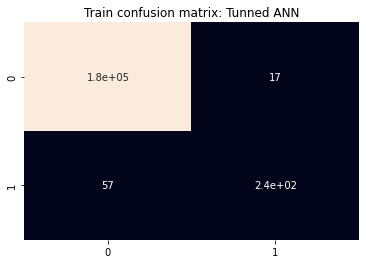

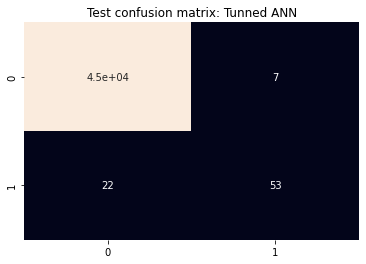


roc auc score train 0.9055821257985115


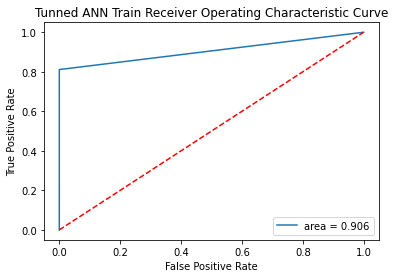


roc auc score test 0.8532559014181101


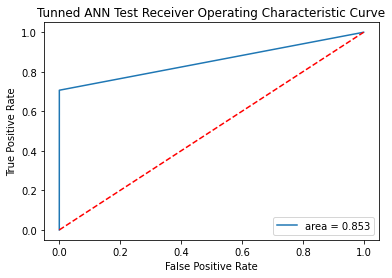

1781/1781 [==============================] - 4s 2ms/step

Test accuracy score 0.9994382219725431 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.72      0.82        98

    accuracy                           1.00     56962
   macro avg       0.97      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Completed and saved for model Tunned ANN


In [237]:
y_train_pred = tunned_neural_model.predict(x_train)
y_test_pred = tunned_neural_model.predict(x_test)
y_train_label = np.argmax(y_train, axis= 1)
y_train_pred = np.argmax(y_train_pred, axis= 1)
y_test_label = np.argmax(y_test, axis= 1)
y_test_pred = np.argmax(y_test_pred, axis= 1)

getPerformance(y_train_label, y_train_pred, y_test_label, y_test_pred, 'Tunned ANN')
  
test_y_pred = tunned_neural_model.predict(test_X)
test_y_label = np.argmax(test_y, axis= 1)
test_y_pred = np.argmax(test_y_pred, axis= 1)

print('\nTest accuracy score {} \n'.format(accuracy_score(test_y_label, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y_label, test_y_pred))
print('\nCompleted and saved for model Tunned ANN')
tunned_neural_model.save('Tunned ANN')

As we can see the latest model gave the highest performance now among all the ANN models (f1-score macro= 0.91 with test data).

But again we can use other models as well giving top results.

If we consider both ML and DL models, still random forest classifier gae the highest score of 0.92.

### Anomaly Detection

All the records we have, there is a possibility that we can have anomaly/outliers which lies with large separation as compared to other records. Based on the selected features, we can decide whether a point in feature space is anomaly or not. We can also assign scores to the points implying the chances of being a anomaly.

We can use IsolationForest model to provide anomaly label prediction and scores to the data points.

In [340]:
print(train_X.shape)
print(train_y.shape)

(226378, 30)
(226378, 1)


In [341]:
model  =  IsolationForest(n_estimators=50, max_samples=500, contamination=.05, max_features=10, 
                         bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(train_X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [342]:
anomaly_score = model.decision_function(train_X)
predictions = model.predict(train_X)

In [343]:
anomaly_score[:5]

array([0.12114711, 0.01284614, 0.06780871, 0.11218362, 0.09971792])

In [344]:
print(np.unique(predictions, return_counts=True))

(array([-1,  1]), array([ 11318, 215060]))


In [345]:
anomaly_score_test = model.decision_function(test_X)

The finance data got fit with the model for anomaly detection. Here we got the scores and the labels of anomaly (-1,1)

Now we can visualize the data points with the score values and the predictions.

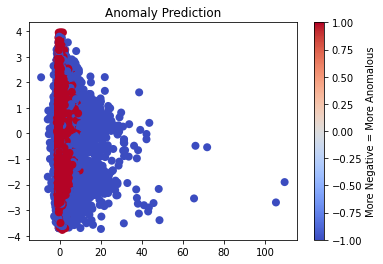

In [346]:
X_pca = PCA(n_components=2, random_state=42).fit_transform(train_X.values)
s = plt.scatter(X_pca[:,0], X_pca[:,1], c=predictions, cmap='coolwarm', linewidths=2)
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.title('Anomaly Prediction')
plt.show()

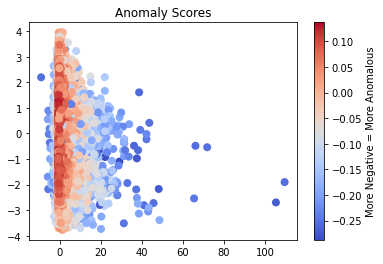

In [347]:
X_pca = PCA(n_components=2, random_state=42).fit_transform(train_X.values)
s = plt.scatter(X_pca[:,0], X_pca[:,1], c=anomaly_score, cmap='coolwarm', linewidths=2)
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.title('Anomaly Scores')
plt.show()

Now lets try to add this anomaly scores to our input data as a feature and check the performance.

Before that, we need to fit a model (Random Forest) with the original data.

In [348]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, 
                                                                     stratify= train_y,
                                                                     test_size= 0.2, random_state= 0)

In [349]:
rf = RandomForestClassifier(class_weight='balanced')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.



Model performance RF with original data

accuracy score train 1.0
accuracy score test 0.9993594840533616

Train classification report: RF with original data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       1.00      1.00      1.00       302

    accuracy                           1.00    181102
   macro avg       1.00      1.00      1.00    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: RF with original data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.90      0.69      0.78        75

    accuracy                           1.00     45276
   macro avg       0.95      0.85      0.89     45276
weighted avg       1.00      1.00      1.00     45276





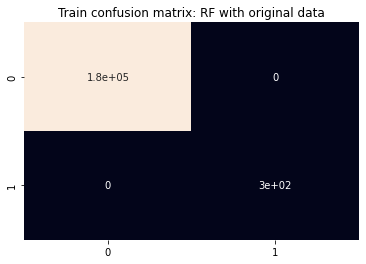

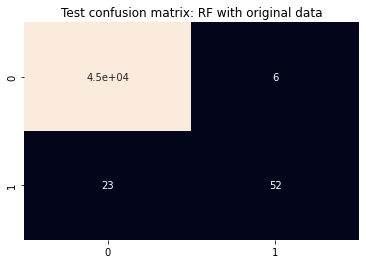


roc auc score train 1.0


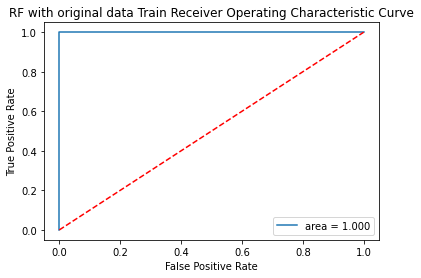


roc auc score test 0.8466002964536182


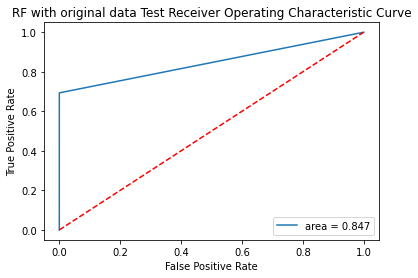


Test accuracy score 0.9994557775359011 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.72      0.82        98

    accuracy                           1.00     56962
   macro avg       0.97      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [350]:
rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
getPerformance(y_train, y_train_pred, y_test, y_test_pred, 'RF with original data')
test_y_pred = rf.predict(test_X)
print('\nTest accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Random forest with original data gave a good performance with f-score macro as 0.91.

Now we can add the anomaly scores to the input and fit a new model.

In [351]:
train_X['Anomaly Score'] = anomaly_score
test_X['Anomaly Score'] = anomaly_score_test

In [352]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, 
                                                                     stratify= train_y,
                                                                     test_size= 0.2, random_state= 0)

In [353]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(test_X.shape)
print(test_y.shape)

(181102, 31)
(181102, 1)
(45276, 31)
(45276, 1)
(56962, 31)
(56962, 1)


In [354]:
rf_anmly = RandomForestClassifier(class_weight='balanced')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.



Model performance RF with original data and anomaly score

accuracy score train 1.0
accuracy score test 0.9993594840533616

Train classification report: RF with original data and anomaly score

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       1.00      1.00      1.00       302

    accuracy                           1.00    181102
   macro avg       1.00      1.00      1.00    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: RF with original data and anomaly score

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.90      0.69      0.78        75

    accuracy                           1.00     45276
   macro avg       0.95      0.85      0.89     45276
weighted avg       1.00      1.00      1.00     45276





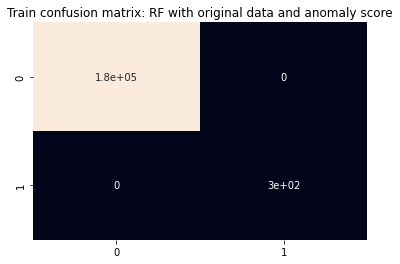

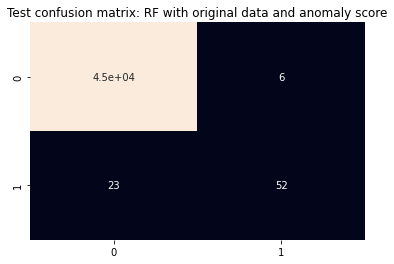


roc auc score train 1.0


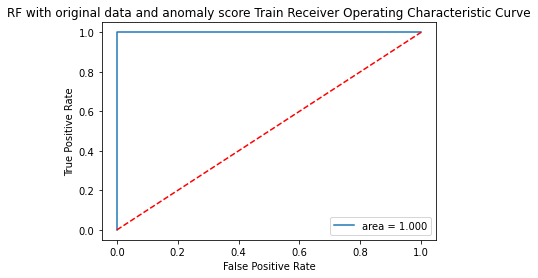


roc auc score test 0.8466002964536182


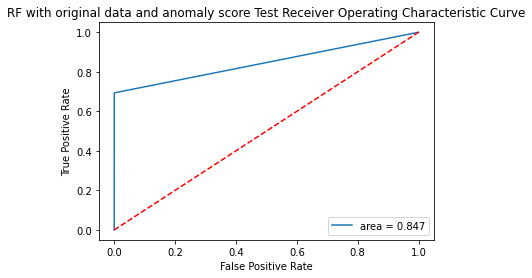


Test accuracy score 0.9994557775359011 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.71      0.82        98

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [355]:
rf_anmly.fit(x_train, y_train)
y_train_pred = rf_anmly.predict(x_train)
y_test_pred = rf_anmly.predict(x_test)
getPerformance(y_train, y_train_pred, y_test, y_test_pred, 'RF with original data and anomaly score')
test_y_pred = rf_anmly.predict(test_X)
print('\nTest accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Random forest model trained with original data and the anomaly score gave very good performance (f1-score macro= 0.91) same as the previous model.

So yes, we can use the anomaly score as a new feature, but it would be optional as we didnt see much difference in the two performances.

We didnt see much difference in f1-score is may be because the score we got is not a useful feature to detect froudulent transacations, as the anolamaly model detects the anomaly based on selected features, so there is guarentee that the anomaly data points will be the froud transaction.

#### Threshold for label prediction

From all the ML model we have, we got the highest score (f-score macro= 0.92) in random forest with oversampled.

Now we can consider the random forest model with oversampled data as final model.

But for thresholding, we can use the random forest model with original data.

In [356]:
finance_train = pd.read_pickle('finance_train.pkl')
finance_test = pd.read_pickle('finance_test.pkl')

In [357]:
train_X = finance_train.drop(['Class'], axis=1)
train_y = finance_train[['Class']]

test_X = finance_test.drop(['Class'], axis=1)
test_y = finance_test[['Class']]

In [358]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, 
                                                                     stratify= train_y,
                                                                     test_size= 0.2, random_state= 0)

In [359]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(test_X.shape)
print(test_y.shape)

(181102, 30)
(181102, 1)
(45276, 30)
(45276, 1)
(56962, 30)
(56962, 1)



Model performance RF with original data

accuracy score train 1.0
accuracy score test 0.9993594840533616

Train classification report: RF with original data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    180800
           1       1.00      1.00      1.00       302

    accuracy                           1.00    181102
   macro avg       1.00      1.00      1.00    181102
weighted avg       1.00      1.00      1.00    181102


Test classification report: RF with original data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45201
           1       0.90      0.69      0.78        75

    accuracy                           1.00     45276
   macro avg       0.95      0.85      0.89     45276
weighted avg       1.00      1.00      1.00     45276





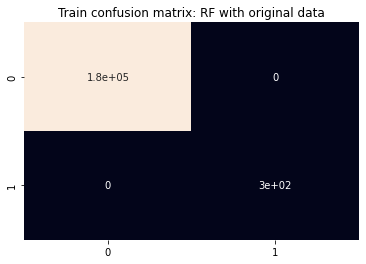

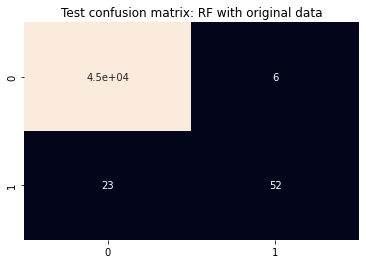


roc auc score train 1.0


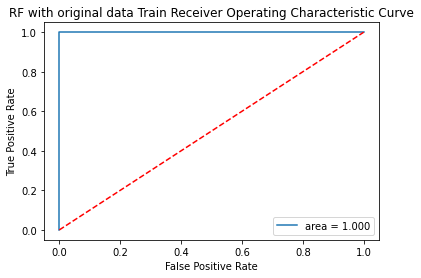


roc auc score test 0.8466002964536182


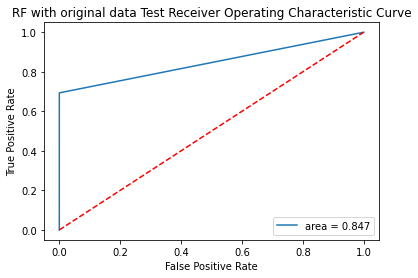


Test accuracy score 0.9994557775359011 

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.72      0.82        98

    accuracy                           1.00     56962
   macro avg       0.97      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [366]:
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
test_y_pred = rf.predict(test_X)
getPerformance(y_train, y_train_pred, y_test, y_test_pred, 'RF with original data')
print('\nTest accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

In [367]:
y_train_pred_proba = rf.predict_proba(x_train)[:, 1]
y_test_pred_proba = rf.predict_proba(x_test)[:, 1]
test_y_pred_proba = rf.predict_proba(test_X)[:, 1]

In [368]:
fpr, tpr, th = roc_curve(y_train, y_train_pred)

In [369]:
f1_scores = []
cur_th = None
def setClass(val):
  if val > cur_th:
    return 1
  else:
    return 0

for t in th:
  cur_th = t
  y_train_pred = np.array(list(map(setClass, y_train_pred_proba)))
  score = f1_score(y_train, y_train_pred, average= 'macro')
  f1_scores.append(score)

In [370]:
f1_scores = np.array(f1_scores)
max_idx = np.argmax(f1_scores)
final_th = th[max_idx]
final_th

0

In [371]:
cur_th = final_th
y_train_pred = np.array(list(map(setClass, y_train_pred_proba)))
score = f1_score(y_train, y_train_pred, average= 'macro')
score

0.6474639191293603

In [372]:
test_y_pred = np.array(list(map(setClass, test_y_pred_proba)))
score = f1_score(test_y, test_y_pred, average= 'macro')
score

0.5646132750465037

We can take 0 as final threshold value to predict the class labels.

But still without doing thresholding manually, we get much higher f1-score (0.92) directly with the oversampled random forest model.